# SHAP Notebook - Explainable AI 

This notebook primarily uses SHAP to explain multiple learners on the proteomics and genomics datasets from GDSC and CCLE

## Import Data

In [1]:
import pandas as pd
import pickle

# import GDSC2 drug response data using pickle

with open('data/drug-response/GDSC2/cache_gdsc2.pkl', 'rb') as f:
    gdsc2 = pickle.load(f)
    gdsc2_info = pickle.load(f)

# import CCLE gene expression data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_expression.pkl', 'rb') as f:
    gene_entrez = pickle.load(f)
    ccle = pickle.load(f)

# import CCLE sample info data using pickle

with open('data/gene-expression/CCLE_Public_22Q2/ccle_sample_info.pkl', 'rb') as f:
    ccle_sample_info = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)


# import proteomic expression
with open('data/proteomic-expression/goncalves-2022-cell/goncalve_proteome_fillna_processed.pkl', 'rb') as f:
    joined_full_protein_matrix = pickle.load(f)
    joined_sin_peptile_exclusion_matrix = pickle.load(f)

# import STRING database using pickle

with open('data/protein-interaction/STRING/string_df.pkl', 'rb') as f:
    string_df = pickle.load(f)
    string_df_info = pickle.load(f)
    string_df_alias = pickle.load(f)

# open STRING to goncalves mapping file

with open('data\protein-interaction\STRING\goncalve_to_string_id_df.pkl', 'rb') as f:
    goncalve_to_string_id_df = pickle.load(f)


## Palbociclib GDSC with Goncalves et al proteomics (preprocessed & normalised)

In [2]:
# create feature and target 

import DataFunctions as utils

# create the full dataset

palbociclib_proteomic_df = utils.create_joint_dataset_from_proteome_gdsc('Palbociclib',
                                                                         joined_sin_peptile_exclusion_matrix, gdsc2)

feature_data, label_data = utils.create_feature_and_label(palbociclib_proteomic_df)



### Model ElasticNet - All Features

score using selected features: 2.3212, score using all features: 2.1718


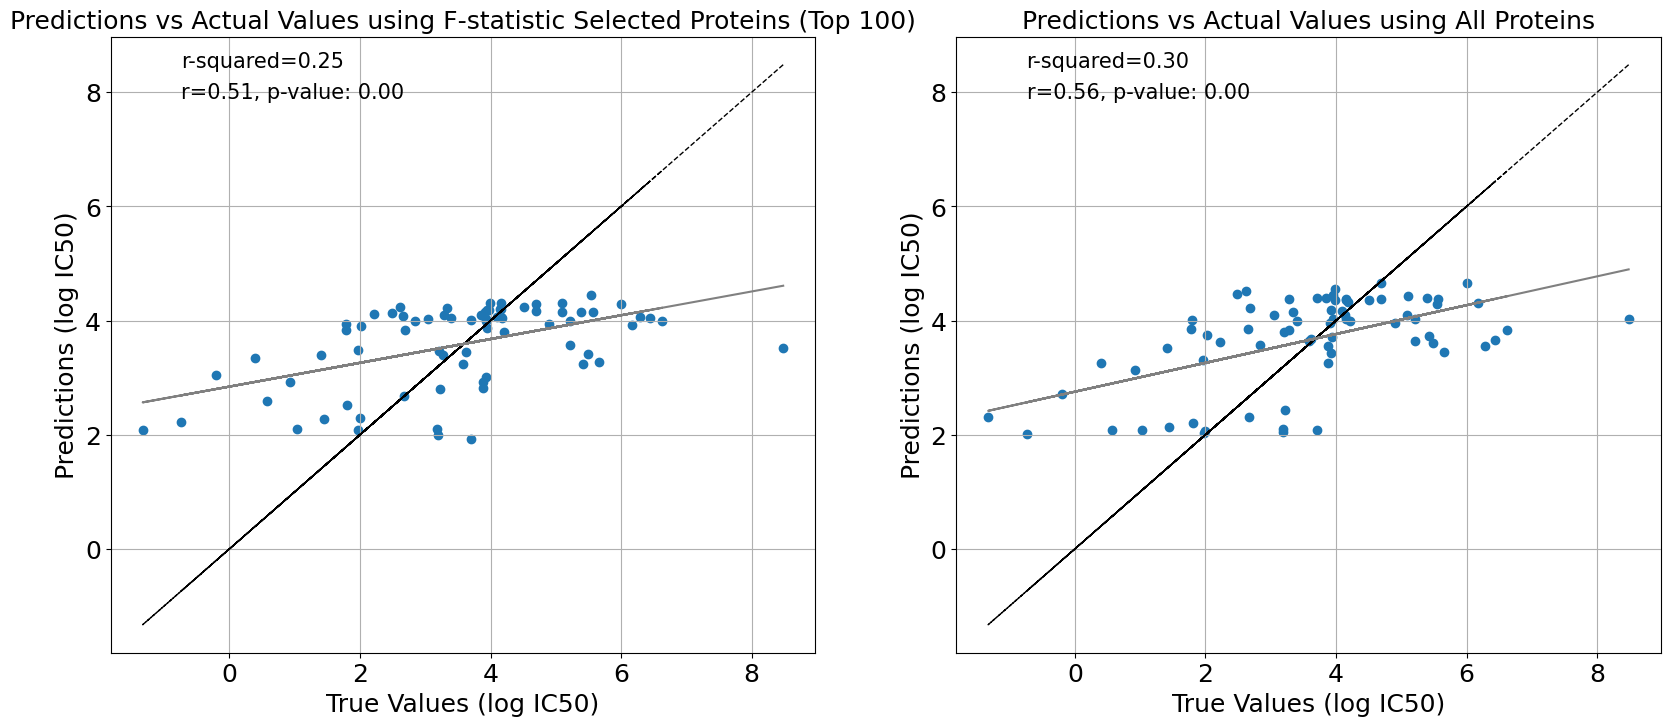

In [8]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import lasso regression model

from sklearn.linear_model import ElasticNet, ElasticNetCV

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression


import numpy as np

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=np.random.randint(1000))

# perform feature selection on the training set

selector = SelectKBest(f_regression, k=100)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# train the model on the selected features

model = ElasticNet()
model.fit(X_train[selected_features], y_train)

model_all = ElasticNet()
model_all.fit(X_train, y_train)

# get the predictions

y_pred = model.predict(X_test[selected_features])
predictions_all_features = model_all.predict(X_test)

# get the score


score = mean_squared_error(y_test, y_pred)
score_all = mean_squared_error(y_test, predictions_all_features)

print(
    f'score using selected features: {score:.4f}, score using all features: {score_all:.4f}')

# plot the predictions vs the actual values


# make a 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# for each axis, plot the predictions vs the actual values
vis.plot_predictions_vs_actual_values(y_test, y_pred, ax=ax[0],
                                      title='Predictions vs Actual Values using F-statistic Selected Proteins (Top 100)',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
vis.plot_predictions_vs_actual_values(y_test, predictions_all_features, ax=ax[1],
                                      title='Predictions vs Actual Values using All Proteins',
                                      x_label='True Values (log IC50)', y_label='Predictions (log IC50)',
                                      minitext_size=15)
# show the plot
plt.show()


#### SHAP Analysis

In [12]:
# Use SHAP to extract feature importance

import shap

# create the explainer

explainer = shap.LinearExplainer(model_all, X_train)

# get the shap values

shap_values = explainer(X_test)

In [22]:
print(shap_values.shape)
print(X_test.shape)

(74, 6692)
(74, 6692)


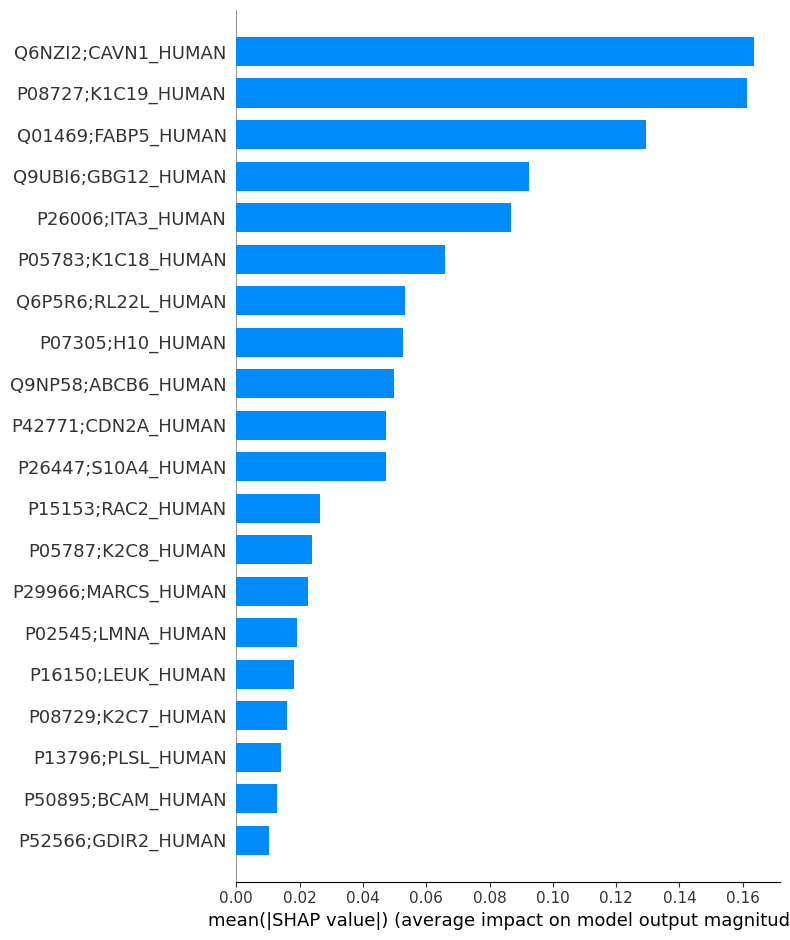

In [13]:
# plot the shap values

shap.summary_plot(shap_values, X_test, plot_type="bar")


#### Monte Carlo CV with SHAP

In [23]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# import elastic net regression model and random forest regression model

from sklearn.linear_model import ElasticNet

repeats = 100
test_size = 0.1
exp_ids = ['All Proteins']
feature_selection_size = [feature_data.shape[1]]

data = []
data_column_names = ['exp_id', 'random_seed', 'score', 'y_pred', 'y_test', 'shap_features', 'x_test', 'pearson_corr', 'pearson_p_val', 'r_squared']

for i in range(repeats):
    random_seed = int(np.random.random()*100000)
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=test_size, 
                                                        random_state=random_seed)

    for exp_id, k in zip(exp_ids, feature_selection_size):
        model = ElasticNet()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)
        corr, p_val = pearsonr(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)

        explainer = shap.LinearExplainer(model_all, X_train)
        shap_values = explainer(X_test)
        # print debug info
        print(f'iteration: {i}, score: {score:.4f}, pearson corr: {corr:.4f}, pearson p_val: {p_val:.4f}, r_squared: {r_squared:.4f}')

        row = [exp_id, random_seed, score, y_pred, y_test.tolist(), shap_values, X_test, corr, p_val, r_squared]
        data.append(row)

# save result in a dataframe
collection_df = pd.DataFrame(data, columns=data_column_names)



iteration: 0, score: 1.8290, pearson corr: 0.6074, pearson p_val: 0.0000, r_squared: 0.3496
iteration: 1, score: 1.4865, pearson corr: 0.5968, pearson p_val: 0.0000, r_squared: 0.3406
iteration: 2, score: 1.7786, pearson corr: 0.5929, pearson p_val: 0.0000, r_squared: 0.3181
iteration: 3, score: 1.7923, pearson corr: 0.6416, pearson p_val: 0.0000, r_squared: 0.3788
iteration: 4, score: 2.3915, pearson corr: 0.6881, pearson p_val: 0.0000, r_squared: 0.3765
iteration: 5, score: 1.6307, pearson corr: 0.4982, pearson p_val: 0.0000, r_squared: 0.2477
iteration: 6, score: 1.8614, pearson corr: 0.5714, pearson p_val: 0.0000, r_squared: 0.3075
iteration: 7, score: 1.8275, pearson corr: 0.5060, pearson p_val: 0.0000, r_squared: 0.2550
iteration: 8, score: 1.8178, pearson corr: 0.6152, pearson p_val: 0.0000, r_squared: 0.3509
iteration: 9, score: 1.5611, pearson corr: 0.5923, pearson p_val: 0.0000, r_squared: 0.3399
iteration: 10, score: 1.1744, pearson corr: 0.6340, pearson p_val: 0.0000, r_squ

#### Mean Abs Value Bar Plot Visualisation

55


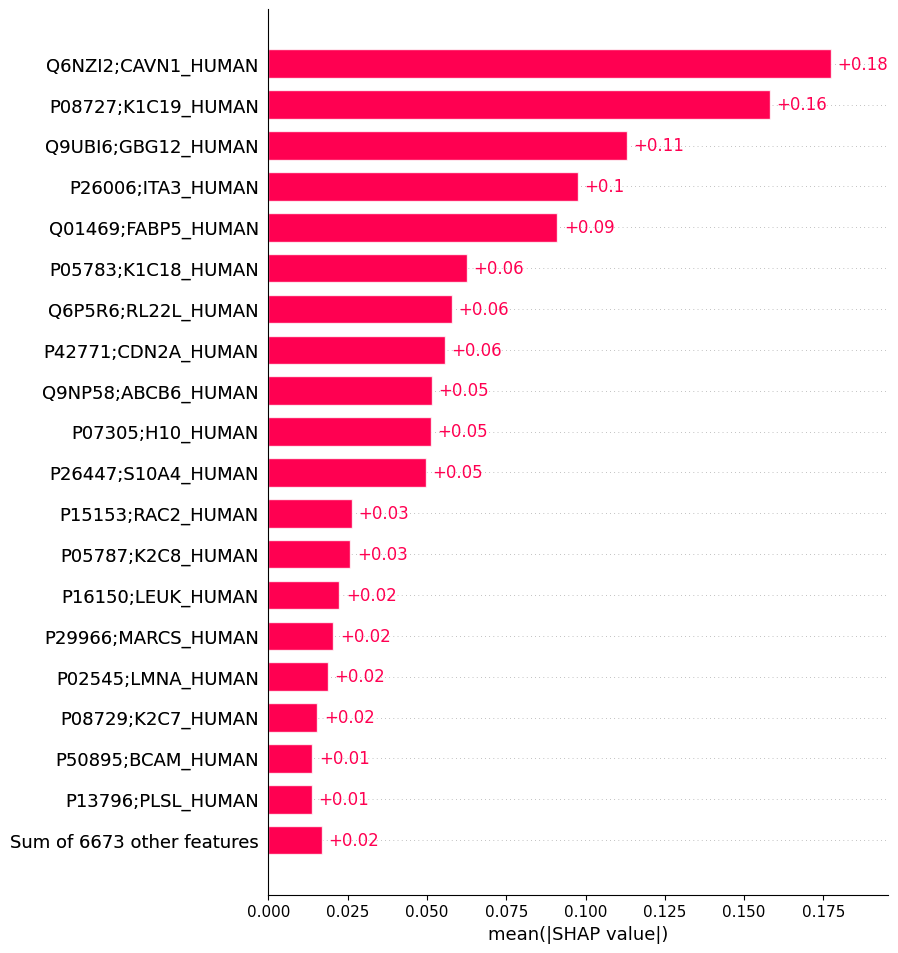

In [41]:
shap_plot_vals = [(x, y) for x, y in zip(collection_df['shap_features'], collection_df['x_test'])]

# plot a random row of the shap values 

random_row = int(np.random.random()*repeats)
print(random_row)
shap_values = shap_plot_vals[random_row][0]
X_test = shap_plot_vals[random_row][1] 

shap.plots.bar(shap_values, max_display=20, show=False)

# shows mean abs value

#### Extract feature importance from a single run

In [50]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_test.columns

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
feature_importance.head(20)




,col_name,feature_importance_vals
3137,Q6NZI2;CAVN1_HUMAN,0.177357
361,P08727;K1C19_HUMAN,0.158058
2939,Q9UBI6;GBG12_HUMAN,0.113114
240,P26006;ITA3_HUMAN,0.097477
4048,Q01469;FABP5_HUMAN,0.091112
1100,P05783;K1C18_HUMAN,0.062602
5349,Q6P5R6;RL22L_HUMAN,0.057874
2355,P42771;CDN2A_HUMAN,0.055530
1983,Q9NP58;ABCB6_HUMAN,0.051597
5765,P07305;H10_HUMAN,0.051182


#### Max Value Bar Plot Visualisation

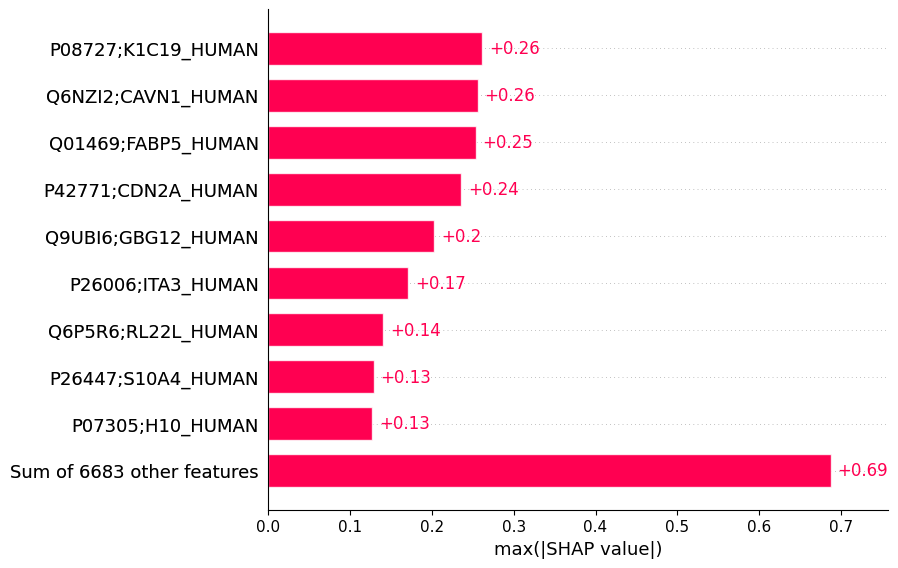

In [42]:
shap.plots.bar(shap_values.abs.max(0))


#### Beeswarm Visualisation of All Iterations

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


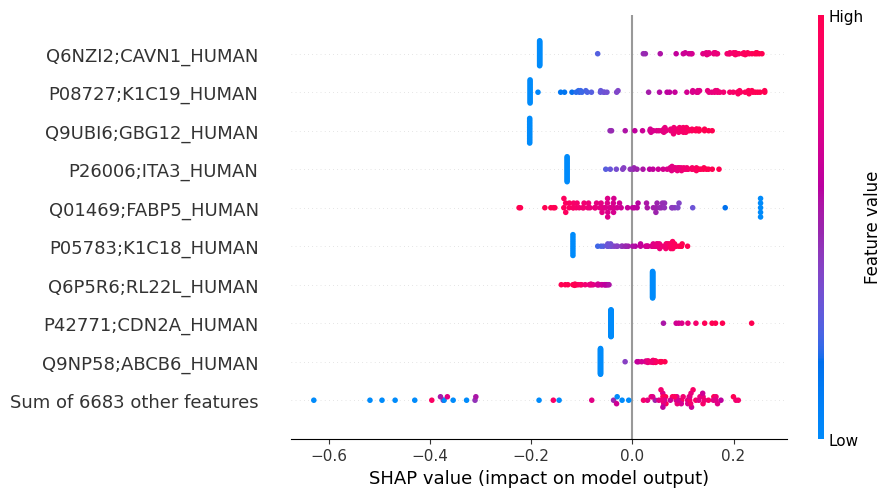

In [43]:
shap.plots.beeswarm(shap_values)


### Evaluating Multiple Models - All Features

In [3]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model

from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model

from sklearn.svm import SVR

# import elastic net regression model

from sklearn.linear_model import ElasticNet

# import simple mlp regression model

from sklearn.neural_network import MLPRegressor

# import xgb regression model

from xgboost import XGBRegressor

# import k nearest neighbors regression model

from sklearn.neighbors import KNeighborsRegressor

import numpy as np

random_state_for_split = np.random.randint(1000)
random_state_for_model = np.random.randint(1000)

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=random_state_for_split)


# create a list of models 

models = [RandomForestRegressor(), 
          SVR(), 
          ElasticNet(), 
          MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=1000),
          XGBRegressor(), 
          KNeighborsRegressor()]

# fit the models

for m in models:
    # print the model name
    print('current model: ', m.__class__.__name__)
    m.fit(X_train, y_train)

# get the predictions

prediction_array = []

for m in models:
    prediction_array.append(m.predict(X_test))

# get the score

score_array = []

for i in range(len(models)):
    score_array.append(mean_squared_error(y_test, prediction_array[i]))


current model:  RandomForestRegressor
current model:  SVR
current model:  ElasticNet
current model:  MLPRegressor
current model:  XGBRegressor
current model:  KNeighborsRegressor


#### Better plot formatting

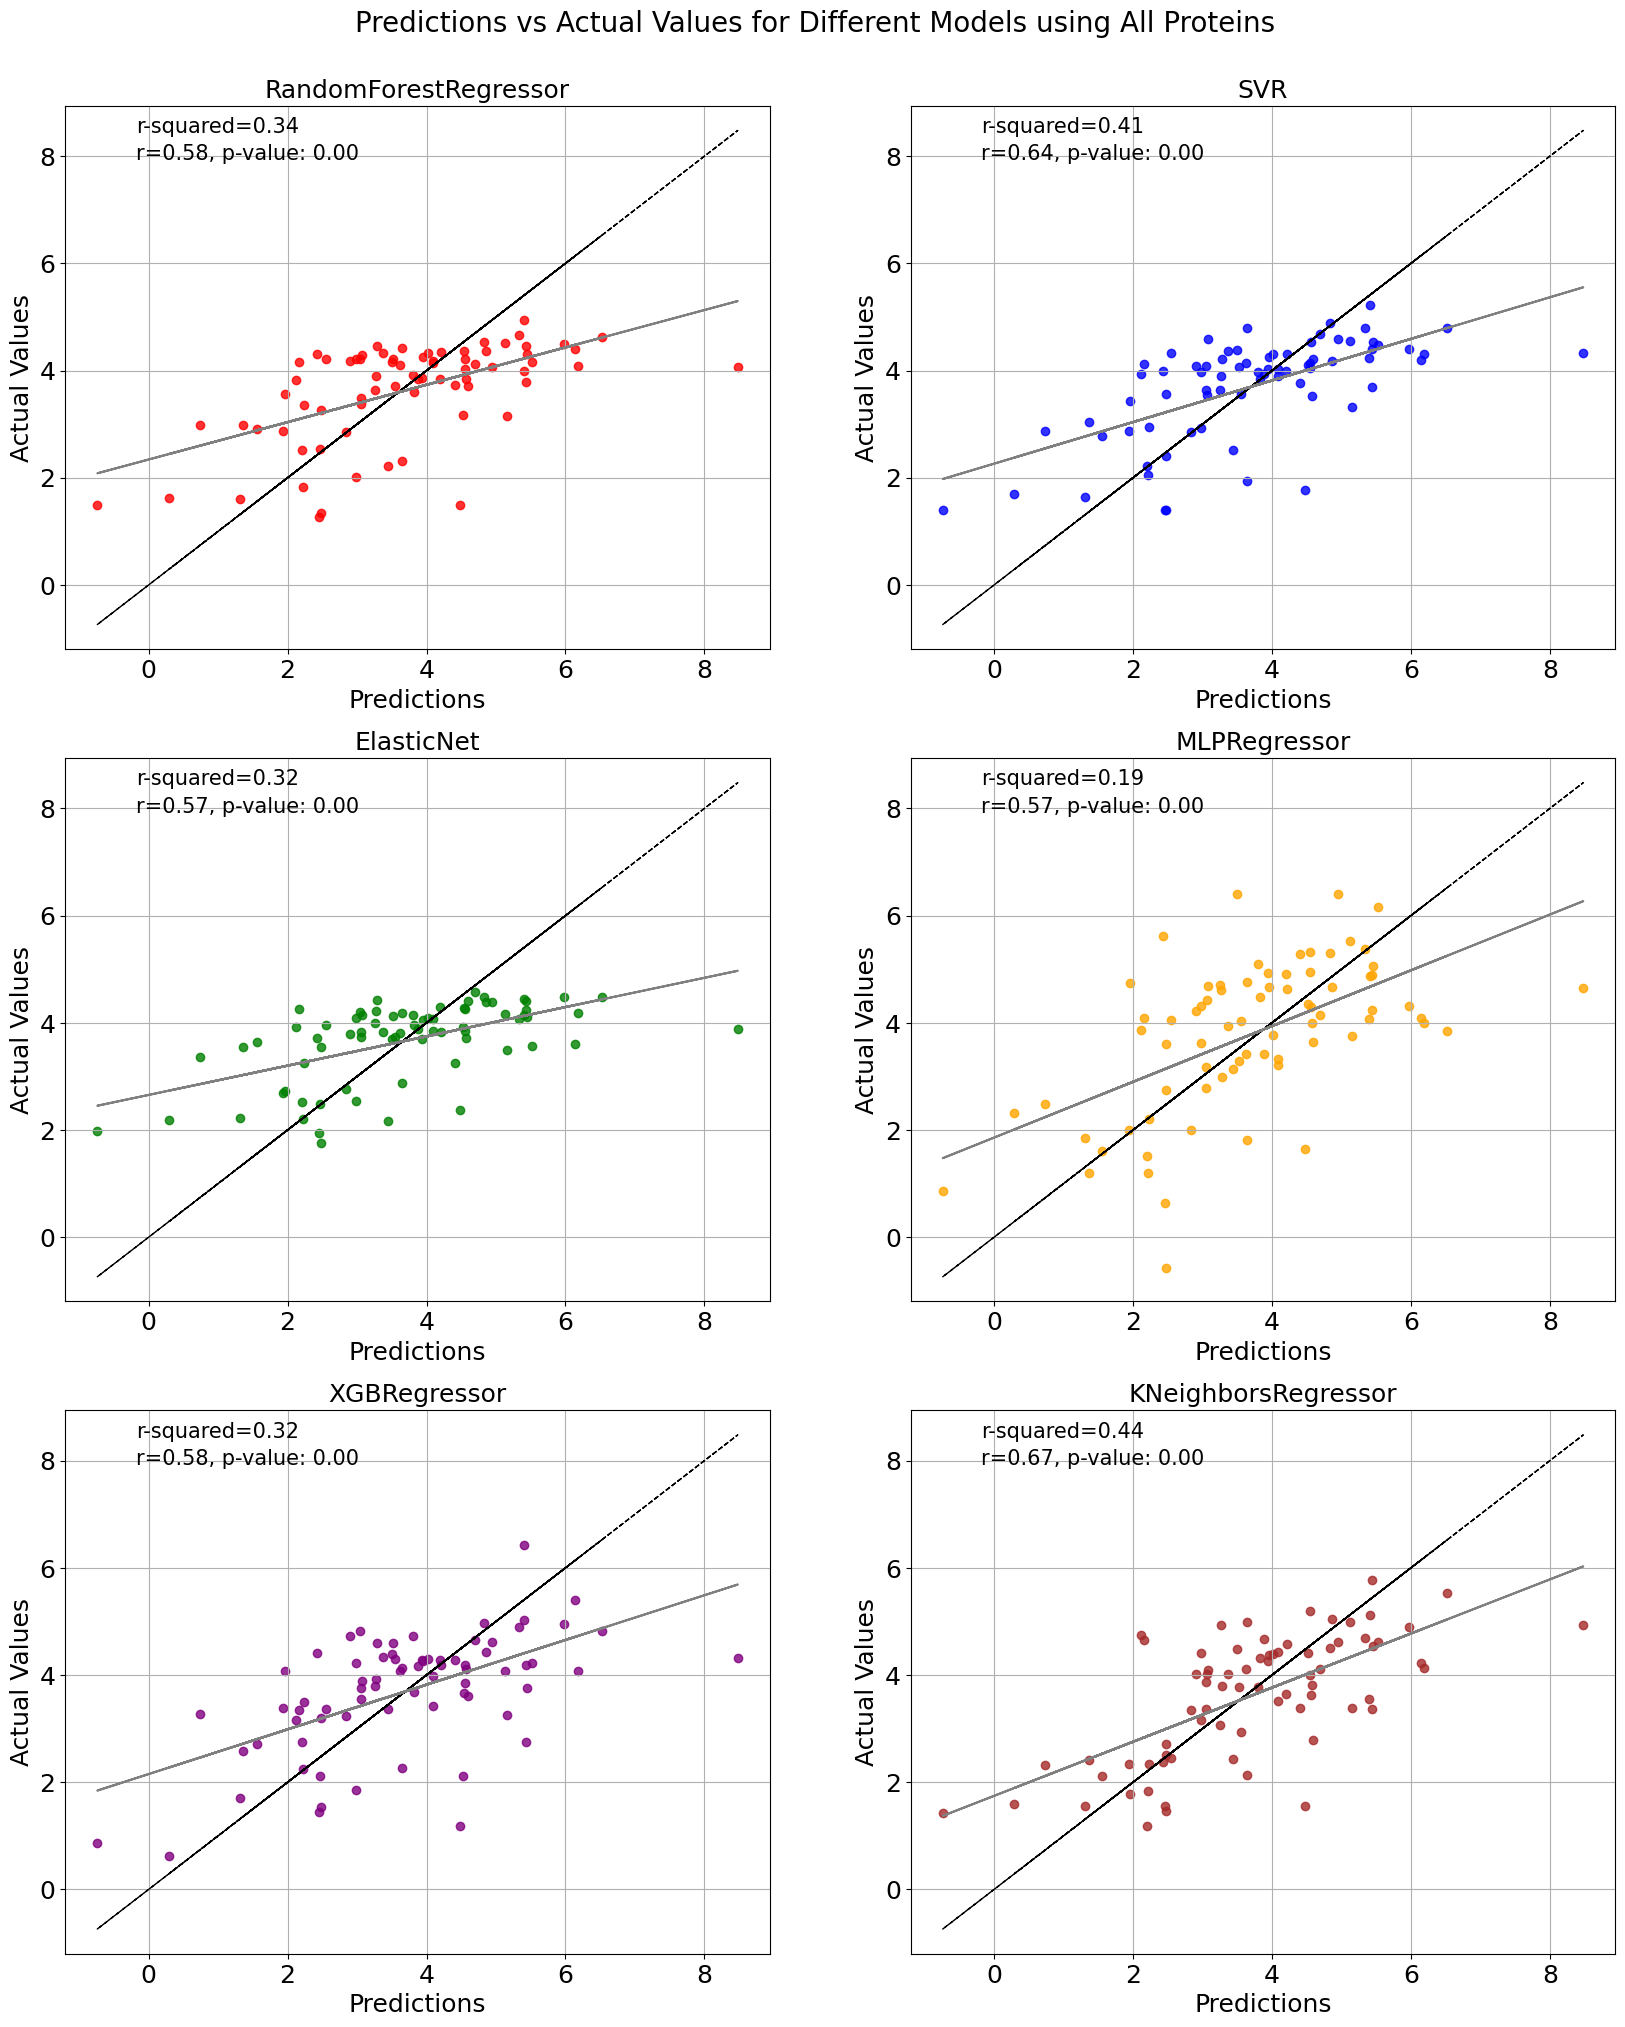

In [4]:
# plot the predictions vs the actual values
# make a 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(20, 24))

# title the overall plot

fig.suptitle('Predictions vs Actual Values for Different Models using All Proteins', fontsize=20, y=0.92)

# use the vis module to plot the predictions vs the actual values for each model

# create six distinct colors for the plot

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(len(models)):
    vis.plot_predictions_vs_actual_values(y_test,
                                            prediction_array[i],
                                            models[i].__class__.__name__,
                                            ax=ax[i//2, i % 2],
                                            x_label='Predictions', y_label='Actual Values', minitext_size=15,
                                            **{'color': colors[i], 'alpha': 0.8})


# show the plot
plt.show()


#### SHAP Analysis

WARNING: SHAP cannot analyse so many featurees at once so the notebook dies while memory is pushed to the limit

DO NOT USE kernalexplainer!!!

In [5]:
import shap

# create a list of shap values for each model

shap_values = []

randomForest = models[0]

print('Progress: reaching random forest')

explainer = shap.TreeExplainer(randomForest, X_train)
shap_vals = explainer.shap_values(X_test)
shap_values.append(shap_vals)


c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Github\ode-biomarker-project\dynamic-marker\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

Progress: reaching random forest


In [6]:

# svr = models[1]
# print('Progress: reaching svr')
# explainer = shap.KernelExplainer(svr.predict, X_train)
# shap_vals = explainer.shap_values(X_test)
# shap_values.append(shap_vals)


Progress: reaching svr


X does not have valid feature names, but SVR was fitted with feature names
  0%|          | 0/74 [01:14<?, ?it/s]


In [ ]:

elasticNet = models[2]
print('Progress: reaching elastic net')
explainer = shap.LinearExplainer(elasticNet, X_train)
shap_vals = explainer(X_test)
shap_values.append(shap_vals)


In [ ]:

# mlp = models[3]
# print('Progress: reaching mlp')
# explainer = shap.KernelExplainer(mlp.predict, X_train)
# shap_vals = explainer.shap_values(X_test)
# shap_values.append(shap_vals)


In [ ]:

xgb = models[4]
print('Progress: reaching xgb')
explainer = shap.TreeExplainer(xgb, X_train)
shap_vals = explainer.shap_values(X_test)
shap_values.append(shap_vals)


In [ ]:

tree = models[5]
print('Progress: reaching tree')
explainer = shap.TreeExplainer(tree, X_train)
shap_vals = explainer.shap_values(X_test)
shap_values.append(shap_vals)


In [ ]:
# plot shap values

shap.plots.bar(shap_values, max_display=20, show=False)



### Multiple Models - F-test Selected Features

In [5]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model

from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model

from sklearn.svm import SVR

# import elastic net regression model

from sklearn.linear_model import ElasticNet

# import simple mlp regression model

from sklearn.neural_network import MLPRegressor

# import xgb regression model

from xgboost import XGBRegressor

# import k nearest neighbors regression model

from sklearn.neighbors import KNeighborsRegressor

# feature selection 

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression

import numpy as np

random_state_for_split = np.random.randint(1000)
random_state_for_model = np.random.randint(1000)
feature_selection_size = 100

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=random_state_for_split)


# perform feature selection on the training set

selector = SelectKBest(f_regression, k=feature_selection_size)
selector.fit(X_train, y_train)

# get the selected features

selected_features = X_train.columns[selector.get_support()]

# create a list of models

models = [RandomForestRegressor(),
          SVR(),
          ElasticNet(),
          MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=1000),
          XGBRegressor(),
          KNeighborsRegressor()]

# fit the models

for m in models:
    # print the model name
    print('current model: ', m.__class__.__name__)
    m.fit(X_train[selected_features], y_train)

# get the predictions

prediction_array = []

for m in models:
    prediction_array.append(m.predict(X_test[selected_features]))

# get the score

score_array = []

for i in range(len(models)):
    score_array.append(mean_squared_error(y_test, prediction_array[i]))


current model:  RandomForestRegressor
current model:  SVR
current model:  ElasticNet
current model:  MLPRegressor
current model:  XGBRegressor
current model:  KNeighborsRegressor


#### Plotting

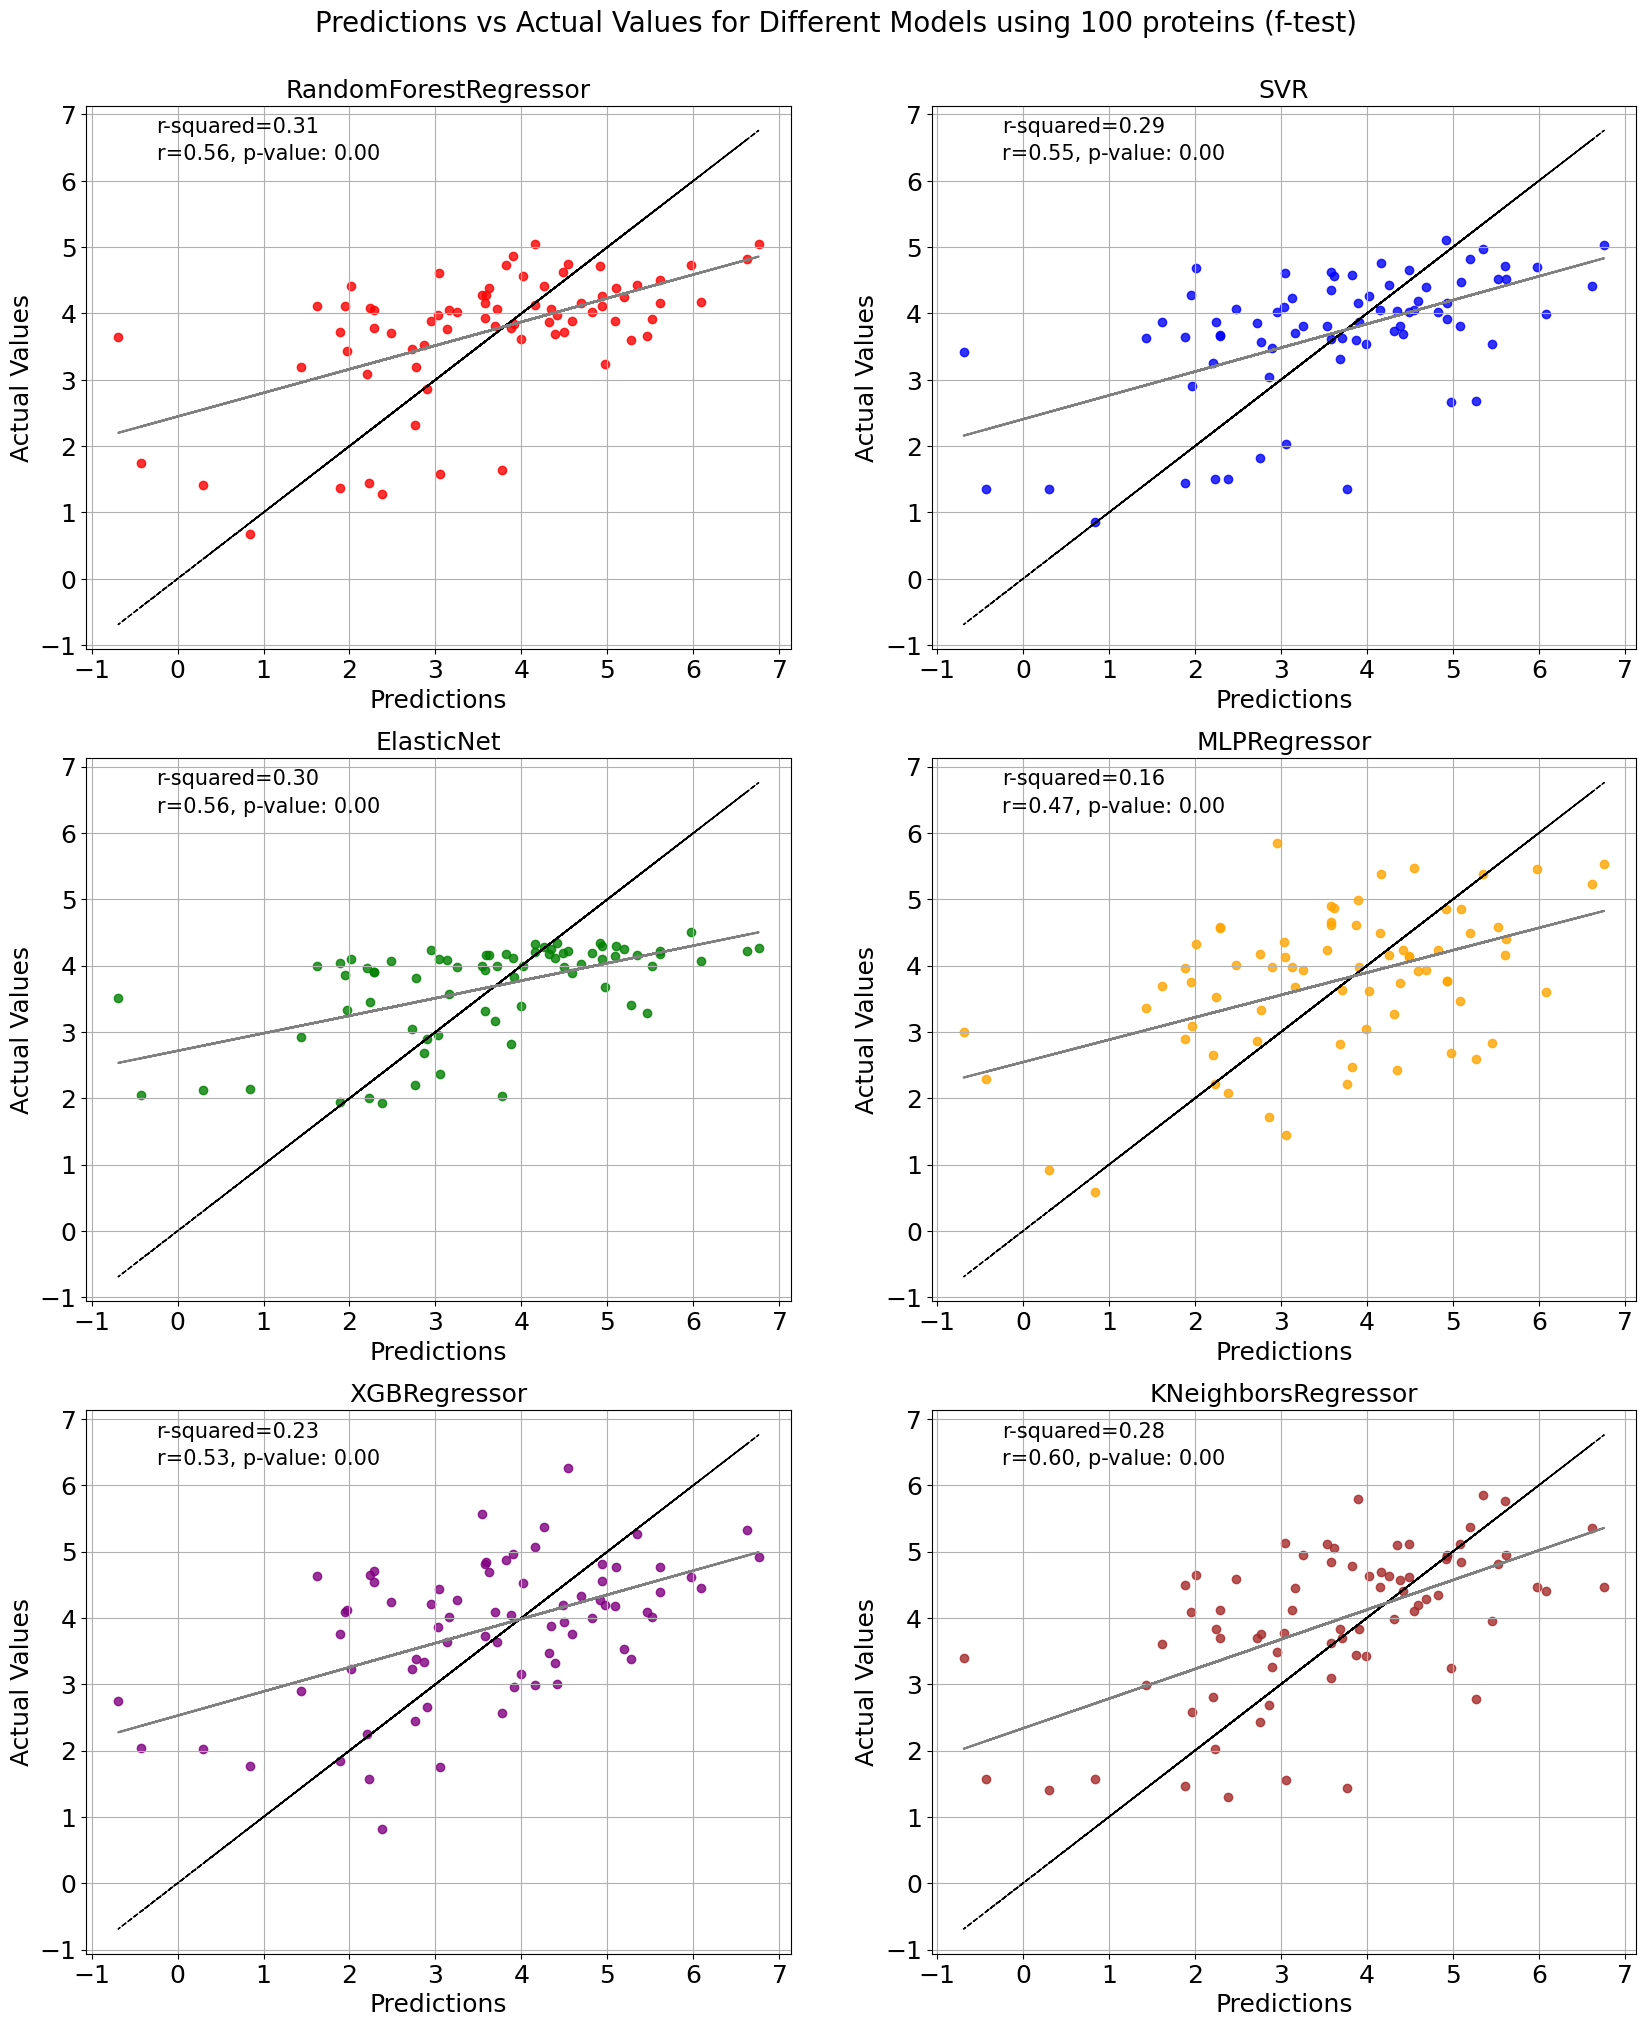

In [6]:
# plot the predictions vs the actual values
# make a 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(20, 24))

# title the overall plot

fig.suptitle(
    'Predictions vs Actual Values for Different Models using 100 proteins (f-test)', fontsize=20, y=0.92)

# use the vis module to plot the predictions vs the actual values for each model

# create six distinct colors for the plot

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(len(models)):
    vis.plot_predictions_vs_actual_values(y_test,
                                          prediction_array[i],
                                          models[i].__class__.__name__,
                                          ax=ax[i//2, i % 2],
                                          x_label='Predictions', y_label='Actual Values', minitext_size=15,
                                          **{'color': colors[i], 'alpha': 0.8})


# show the plot
plt.show()


#### Testing SHAP Kernal on less features

In [7]:
import shap

# create a list of shap values for each model

shap_values = []


In [9]:

mlp = models[3]
print('Progress: reaching mlp')
explainer = shap.KernelExplainer(mlp.predict, X_train[selected_features])
shap_vals = explainer.shap_values(X_test[selected_features])
shap_values.append(shap_vals)


X does not have valid feature names, but MLPRegressor was fitted with feature names
Using 663 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Progress: reaching mlp


  0%|          | 0/74 [00:00<?, ?it/s]X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
  1%|▏         | 1/74 [00:05<06:43,  5.53s/it]X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
  3%|▎         | 2/74 [00:11<06:40,  5.56s/it]X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
  4%|▍         | 3/74 [00:16<06:35,  5.57s/it]X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid feature names, but MLPRegressor was fitted with feature names
  5%|▌         | 4/74 [00:22<06:28,  5.55s/it]X does not have valid feature names, but MLPRegressor was fitted with feature names
X does not have valid 

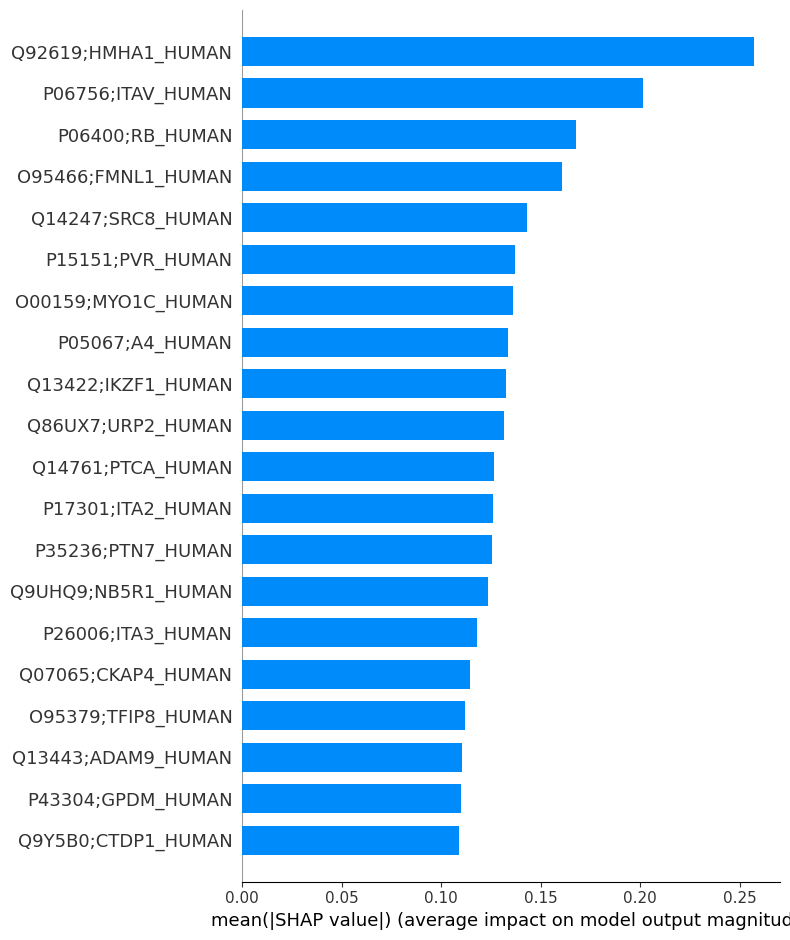

In [11]:
# plot shap values

shap.summary_plot(shap_vals, X_test[selected_features], plot_type="bar")


#### Conclusion

TEST SUCCESSFUL, SHAP can handle 100 features on 32GB RAM

### Multiple Models - Gene-Target Distance Selected Features using the STRING database

#### Computing Interactors

In [4]:
# using STRING database to select the 1st,2nd and 3rd degree neighbours of the drug target

import pandas as pd

drug_targets = ['CDK4', 'CDK6']
first_degree_neighbours = []
second_degree_neighbours = []
third_degree_neighbours = []

for drug_target in drug_targets:
    string_id = utils.get_protein_id_by_name(drug_target, string_df_info, string_df_alias)
    if string_id is not None:
        first_interactors_string_id = utils.get_protein_interactors(string_id, string_df, score_threshold=900)
        for ii in first_interactors_string_id:
            interactor_name = utils.get_protein_name_by_id(ii, goncalve_to_string_id_df, 
                                                           field_name='goncalve_protein_id',
                                                           check_field_name='string_protein_id')
            if interactor_name is not None:
                first_degree_neighbours.append(interactor_name)

first_degree_neighbours = list(set(first_degree_neighbours))

print(f'first degree neighbours size: {len(first_degree_neighbours)}')
print(f'first degree neighbours: {first_degree_neighbours}')

first degree neighbours size: 43
first degree neighbours: ['P49715;CEBPA_HUMAN', 'P16989;YBOX3_HUMAN', 'Q00534;CDK6_HUMAN', 'P04637;P53_HUMAN', 'P49918;CDN1C_HUMAN', 'P24385;CCND1_HUMAN', 'P84022;SMAD3_HUMAN', 'P51946;CCNH_HUMAN', 'P42773;CDN2C_HUMAN', 'P06493;CDK1_HUMAN', 'O60563;CCNT1_HUMAN', 'Q13309;SKP2_HUMAN', 'P42771;CDN2A_HUMAN', 'P12931;SRC_HUMAN', 'Q9BWT6;MND1_HUMAN', 'Q9P287;BCCIP_HUMAN', 'P12004;PCNA_HUMAN', 'P15090;FABP4_HUMAN', 'P11802;CDK4_HUMAN', 'O95067;CCNB2_HUMAN', 'P49841;GSK3B_HUMAN', 'Q00535;CDK5_HUMAN', 'Q13547;HDAC1_HUMAN', 'P07948;LYN_HUMAN', 'Q13951;PEBB_HUMAN', 'Q14186;TFDP1_HUMAN', 'P00519;ABL1_HUMAN', 'P06400;RB_HUMAN', 'Q16543;CDC37_HUMAN', 'Q9P2W1;HOP2_HUMAN', 'O75832;PSD10_HUMAN', 'P31947;1433S_HUMAN', 'P50750;CDK9_HUMAN', 'P51948;MAT1_HUMAN', 'O43502;RA51C_HUMAN', 'P10275;ANDR_HUMAN', 'P08238;HS90B_HUMAN', 'P50613;CDK7_HUMAN', 'P07900;HS90A_HUMAN', 'P20248;CCNA2_HUMAN', 'P24941;CDK2_HUMAN', 'P14635;CCNB1_HUMAN', 'Q13485;SMAD4_HUMAN']


In [5]:
# get the second degree neighbours using first_interactors_string_id

for ii in first_interactors_string_id:
    second_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for sec_ii in second_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(sec_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            second_degree_neighbours.append(interactor_name)

second_degree_neighbours = list(set(second_degree_neighbours + first_degree_neighbours))
print(f'second degree neighbours size: {len(second_degree_neighbours)}')
print(f'second degree neighbours: {second_degree_neighbours}')



second degree neighbours size: 967
second degree neighbours: ['P16104;H2AX_HUMAN', 'Q7KZF4;SND1_HUMAN', 'Q12974;TP4A2_HUMAN', 'P48556;PSMD8_HUMAN', 'Q8N108;MIER1_HUMAN', 'P16070;CD44_HUMAN', 'P33316;DUT_HUMAN', 'P52907;CAZA1_HUMAN', 'P17302;CXA1_HUMAN', 'P35244;RFA3_HUMAN', 'P51946;CCNH_HUMAN', 'Q96R06;SPAG5_HUMAN', 'P11309;PIM1_HUMAN', 'P46940;IQGA1_HUMAN', 'Q96A08;H2B1A_HUMAN', 'Q92466;DDB2_HUMAN', 'Q15717;ELAV1_HUMAN', 'P14625;ENPL_HUMAN', 'Q07021;C1QBP_HUMAN', 'P27986;P85A_HUMAN', 'P17980;PRS6A_HUMAN', 'Q15003;CND2_HUMAN', 'P31751;AKT2_HUMAN', 'P08575;PTPRC_HUMAN', 'P19447;ERCC3_HUMAN', 'Q9Y5N6;ORC6_HUMAN', 'P61244;MAX_HUMAN', 'P55735;SEC13_HUMAN', 'Q9HBM1;SPC25_HUMAN', 'P27448;MARK3_HUMAN', 'P49959;MRE11_HUMAN', 'P54756;EPHA5_HUMAN', 'O43159;RRP8_HUMAN', 'Q14203;DCTN1_HUMAN', 'P07947;YES_HUMAN', 'Q14181;DPOA2_HUMAN', 'Q13330;MTA1_HUMAN', 'Q14204;DYHC1_HUMAN', 'Q13952;NFYC_HUMAN', 'Q9H3D4;P63_HUMAN', 'P18433;PTPRA_HUMAN', 'Q00688;FKBP3_HUMAN', 'Q14114;LRP8_HUMAN', 'P08253;MMP2_HUMA

In [6]:
# get the third degree neighbours using second_interactors_string_id

for ii in second_interactors_string_id:
    third_interactors_string_id = utils.get_protein_interactors(ii, string_df, score_threshold=900)
    for third_ii in third_interactors_string_id:
        interactor_name = utils.get_protein_name_by_id(third_ii, goncalve_to_string_id_df, 
                                                       field_name='goncalve_protein_id',
                                                       check_field_name='string_protein_id')
        if interactor_name is not None:
            third_degree_neighbours.append(interactor_name)

third_degree_neighbours = list(set(third_degree_neighbours + second_degree_neighbours))
print(f'third degree neighbours size: {len(third_degree_neighbours)}')
print(f'third degree neighbours: {third_degree_neighbours}')

third degree neighbours size: 993
third degree neighbours: ['P16104;H2AX_HUMAN', 'Q7KZF4;SND1_HUMAN', 'Q8N108;MIER1_HUMAN', 'P48556;PSMD8_HUMAN', 'Q12974;TP4A2_HUMAN', 'P16070;CD44_HUMAN', 'P33316;DUT_HUMAN', 'P52907;CAZA1_HUMAN', 'P17302;CXA1_HUMAN', 'P35244;RFA3_HUMAN', 'P51946;CCNH_HUMAN', 'Q96R06;SPAG5_HUMAN', 'P11309;PIM1_HUMAN', 'Q15717;ELAV1_HUMAN', 'Q96A08;H2B1A_HUMAN', 'P46940;IQGA1_HUMAN', 'Q92466;DDB2_HUMAN', 'P14625;ENPL_HUMAN', 'Q07021;C1QBP_HUMAN', 'P27986;P85A_HUMAN', 'P17980;PRS6A_HUMAN', 'Q15003;CND2_HUMAN', 'P31751;AKT2_HUMAN', 'P08575;PTPRC_HUMAN', 'P19447;ERCC3_HUMAN', 'Q9Y5N6;ORC6_HUMAN', 'P61244;MAX_HUMAN', 'P55735;SEC13_HUMAN', 'Q9HBM1;SPC25_HUMAN', 'P49959;MRE11_HUMAN', 'P27448;MARK3_HUMAN', 'P54756;EPHA5_HUMAN', 'O43159;RRP8_HUMAN', 'Q14203;DCTN1_HUMAN', 'P07947;YES_HUMAN', 'Q14181;DPOA2_HUMAN', 'Q13330;MTA1_HUMAN', 'Q14204;DYHC1_HUMAN', 'P18433;PTPRA_HUMAN', 'Q13952;NFYC_HUMAN', 'Q9H3D4;P63_HUMAN', 'Q00688;FKBP3_HUMAN', 'Q14114;LRP8_HUMAN', 'P08253;MMP2_HUMAN'

In [7]:
# verify a list is unique

def verify_unique_list(l):
    return len(l) == len(set(l))

# find duplicates in the list

def find_duplicates(l):
    return list(set([x for x in l if l.count(x) > 1]))

print(f'first degree neighbours is unique: {verify_unique_list(first_degree_neighbours)}')

# print the duplicates in first degree neighbours

print(f'duplicates in first degree neighbours: {find_duplicates(first_degree_neighbours)}')

first degree neighbours is unique: True
duplicates in first degree neighbours: []


#### Model Training

In [23]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model

from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model

from sklearn.svm import SVR

# import elastic net regression model

from sklearn.linear_model import ElasticNet

# import simple mlp regression model

from sklearn.neural_network import MLPRegressor

# import xgb regression model

from xgboost import XGBRegressor

# import k nearest neighbors regression model

from sklearn.neighbors import KNeighborsRegressor

# feature selection

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression

import numpy as np

random_state_for_split = np.random.randint(1000)
random_state_for_model = np.random.randint(1000)

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=random_state_for_split)


# perform feature selection using first degree neighbours

selected_features = first_degree_neighbours

# create a list of models

models = [RandomForestRegressor(),
          SVR(),
          ElasticNet(),
          MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=1000),
          XGBRegressor(),
          KNeighborsRegressor()]

# fit the models

for m in models:
    # print the model name
    print('current model: ', m.__class__.__name__)
    m.fit(X_train[selected_features], y_train)

# get the predictions

prediction_array = []

for m in models:
    prediction_array.append(m.predict(X_test[selected_features]))

# get the score

score_array = []

for i in range(len(models)):
    score_array.append(mean_squared_error(y_test, prediction_array[i]))


current model:  RandomForestRegressor
current model:  SVR
current model:  ElasticNet
current model:  MLPRegressor
current model:  XGBRegressor
current model:  KNeighborsRegressor


#### Plotting

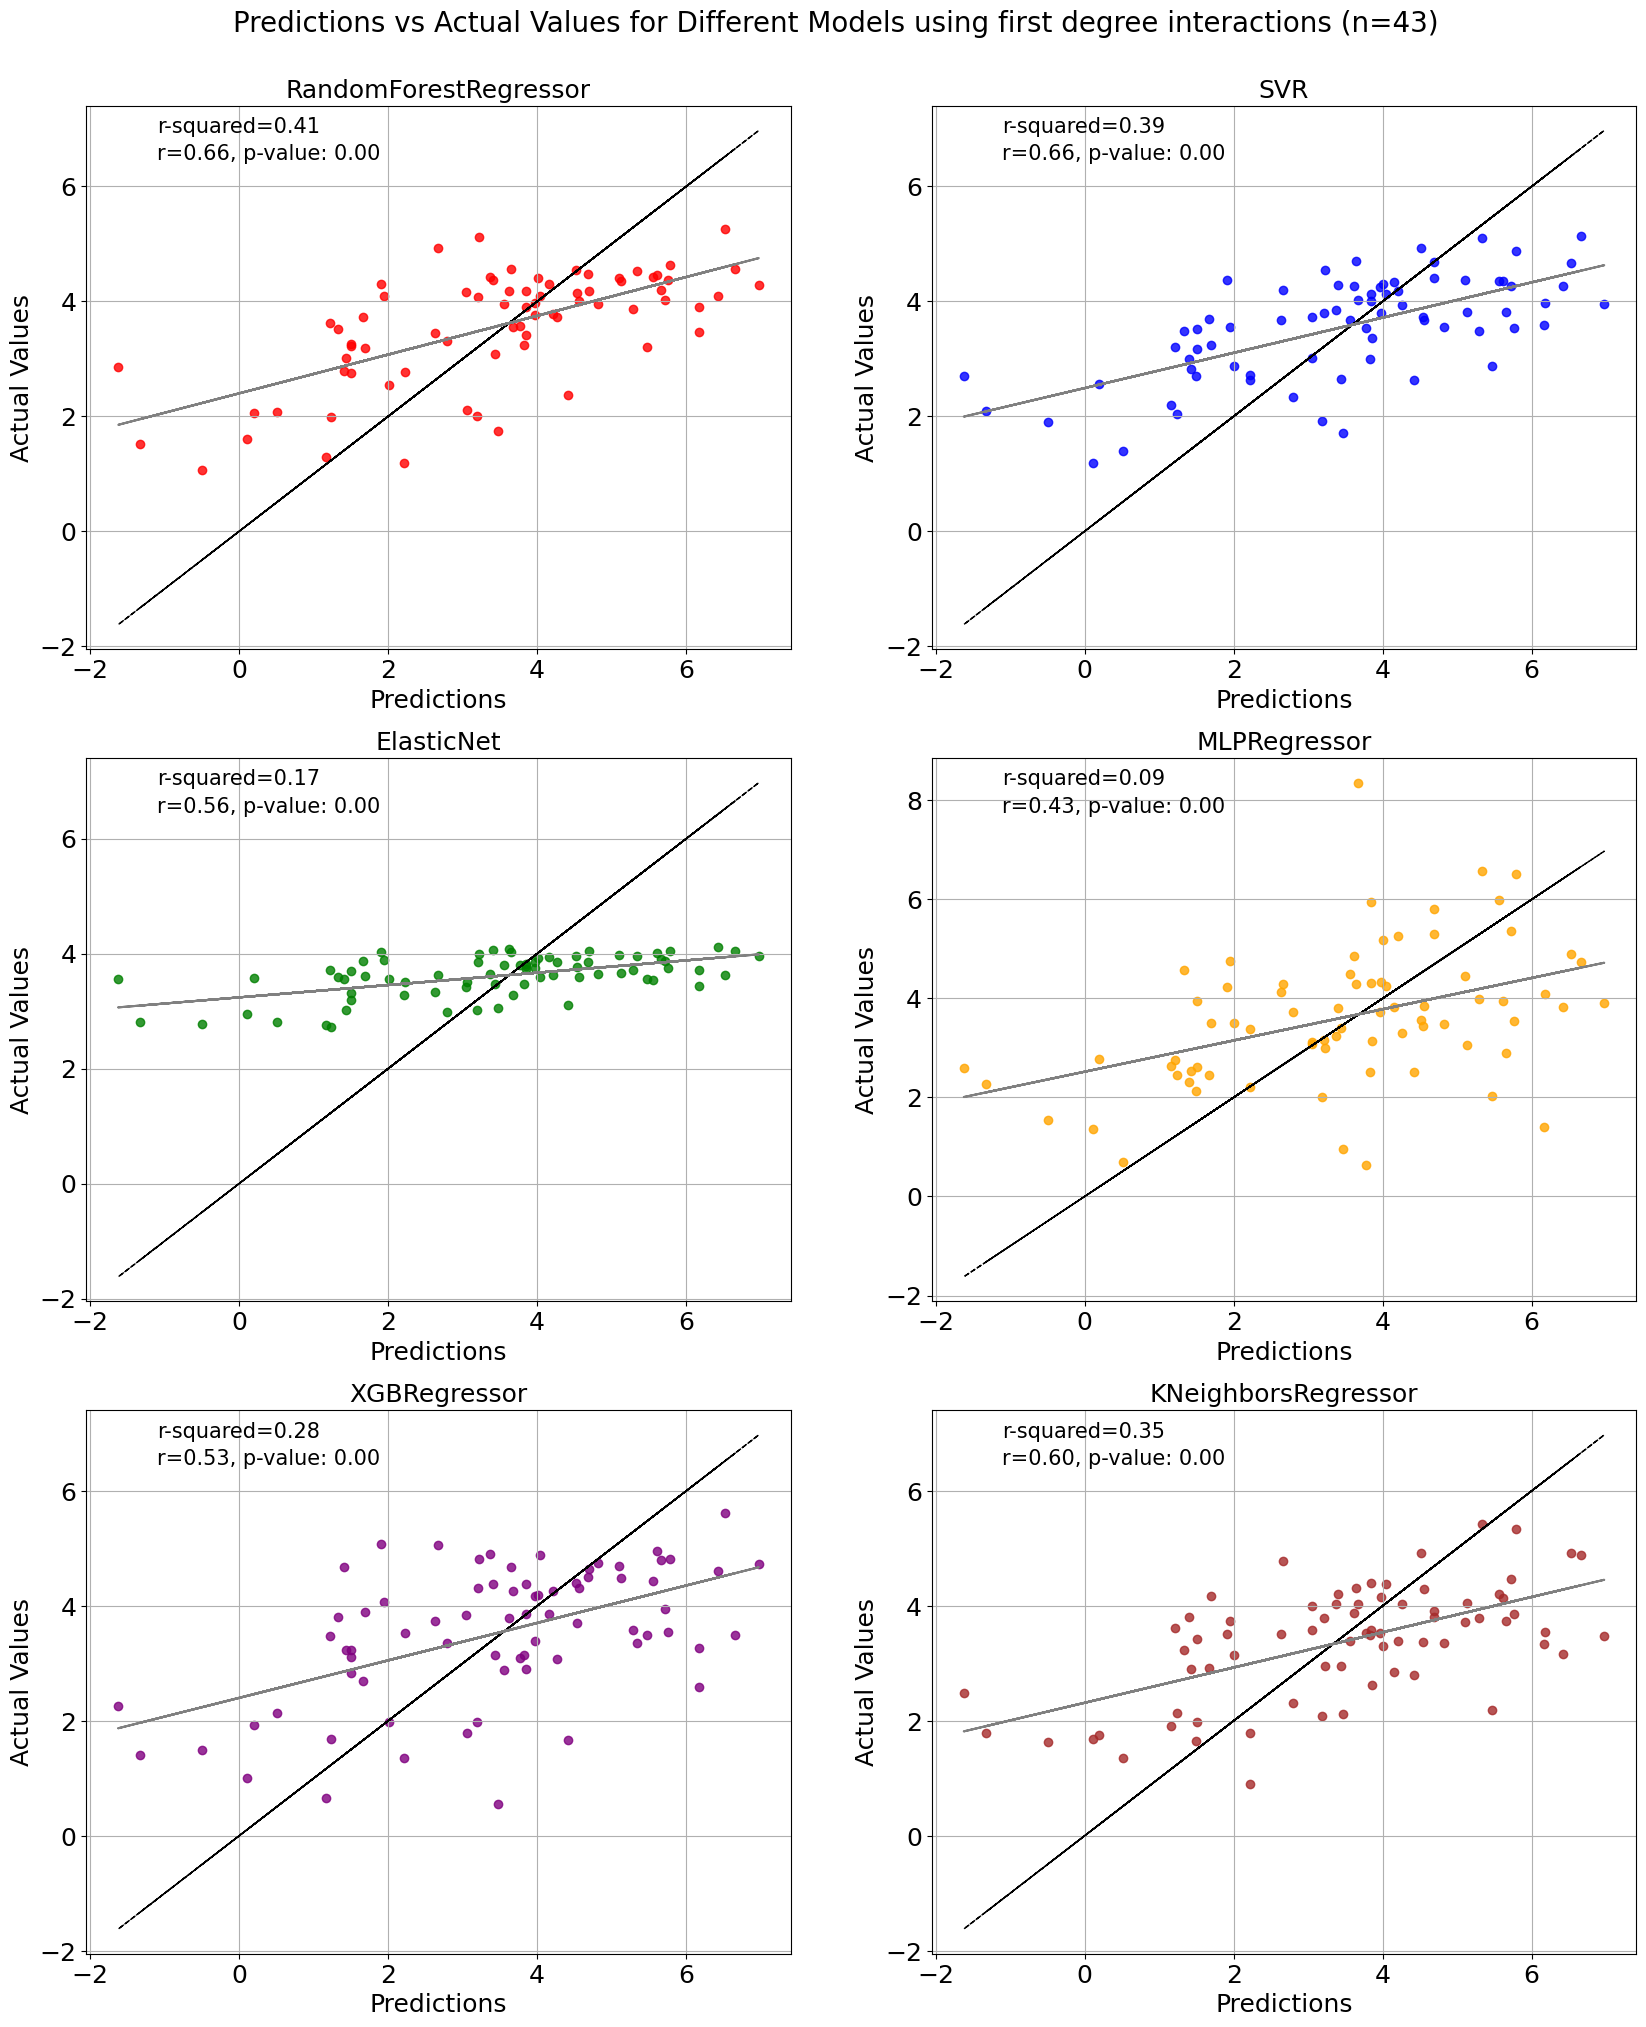

In [25]:
# plot the predictions vs the actual values
# make a 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(20, 24))

# title the overall plot

fig.suptitle(
    'Predictions vs Actual Values for Different Models using first degree interactions (n=43)', fontsize=20, y=0.92)

# use the vis module to plot the predictions vs the actual values for each model

# create six distinct colors for the plot

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(len(models)):
    vis.plot_predictions_vs_actual_values(y_test,
                                          prediction_array[i],
                                          models[i].__class__.__name__,
                                          ax=ax[i//2, i % 2],
                                          x_label='Predictions', y_label='Actual Values', minitext_size=15,
                                          **{'color': colors[i], 'alpha': 0.8})


# show the plot
plt.show()


### Multiple Models - Gene-Target Distance AND F-test Selected Features

#### Selecting using both methods

In [35]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model

from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model

from sklearn.svm import SVR

# import elastic net regression model

from sklearn.linear_model import ElasticNet

# import simple mlp regression model

from sklearn.neural_network import MLPRegressor

# import xgb regression model

from xgboost import XGBRegressor

# import k nearest neighbors regression model

from sklearn.neighbors import KNeighborsRegressor

# feature selection

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression

import numpy as np

random_state_for_split = np.random.randint(1000)
random_state_for_model = np.random.randint(1000)
n_degree_neighbours = second_degree_neighbours
feature_selection_size = 100

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=random_state_for_split)


# perform feature selection on the training set

selector = SelectKBest(f_regression, k=feature_selection_size)
selector.fit(X_train[n_degree_neighbours], y_train)

# get the selected features

selected_features = X_train[n_degree_neighbours].columns[selector.get_support()]

# print(selected_features)

# create a list of models

models = [RandomForestRegressor(),
          SVR(),
          ElasticNet(),
          MLPRegressor(hidden_layer_sizes=(16, 16), max_iter=1000),
          XGBRegressor(),
          KNeighborsRegressor()]

# fit the models

for m in models:
    # print the model name
    print('current model: ', m.__class__.__name__)
    m.fit(X_train[selected_features], y_train)

# get the predictions

prediction_array = []

for m in models:
    prediction_array.append(m.predict(X_test[selected_features]))

# get the score

score_array = []

for i in range(len(models)):
    score_array.append(mean_squared_error(y_test, prediction_array[i]))


current model:  RandomForestRegressor
current model:  SVR
current model:  ElasticNet
current model:  MLPRegressor
current model:  XGBRegressor
current model:  KNeighborsRegressor


#### Plotting

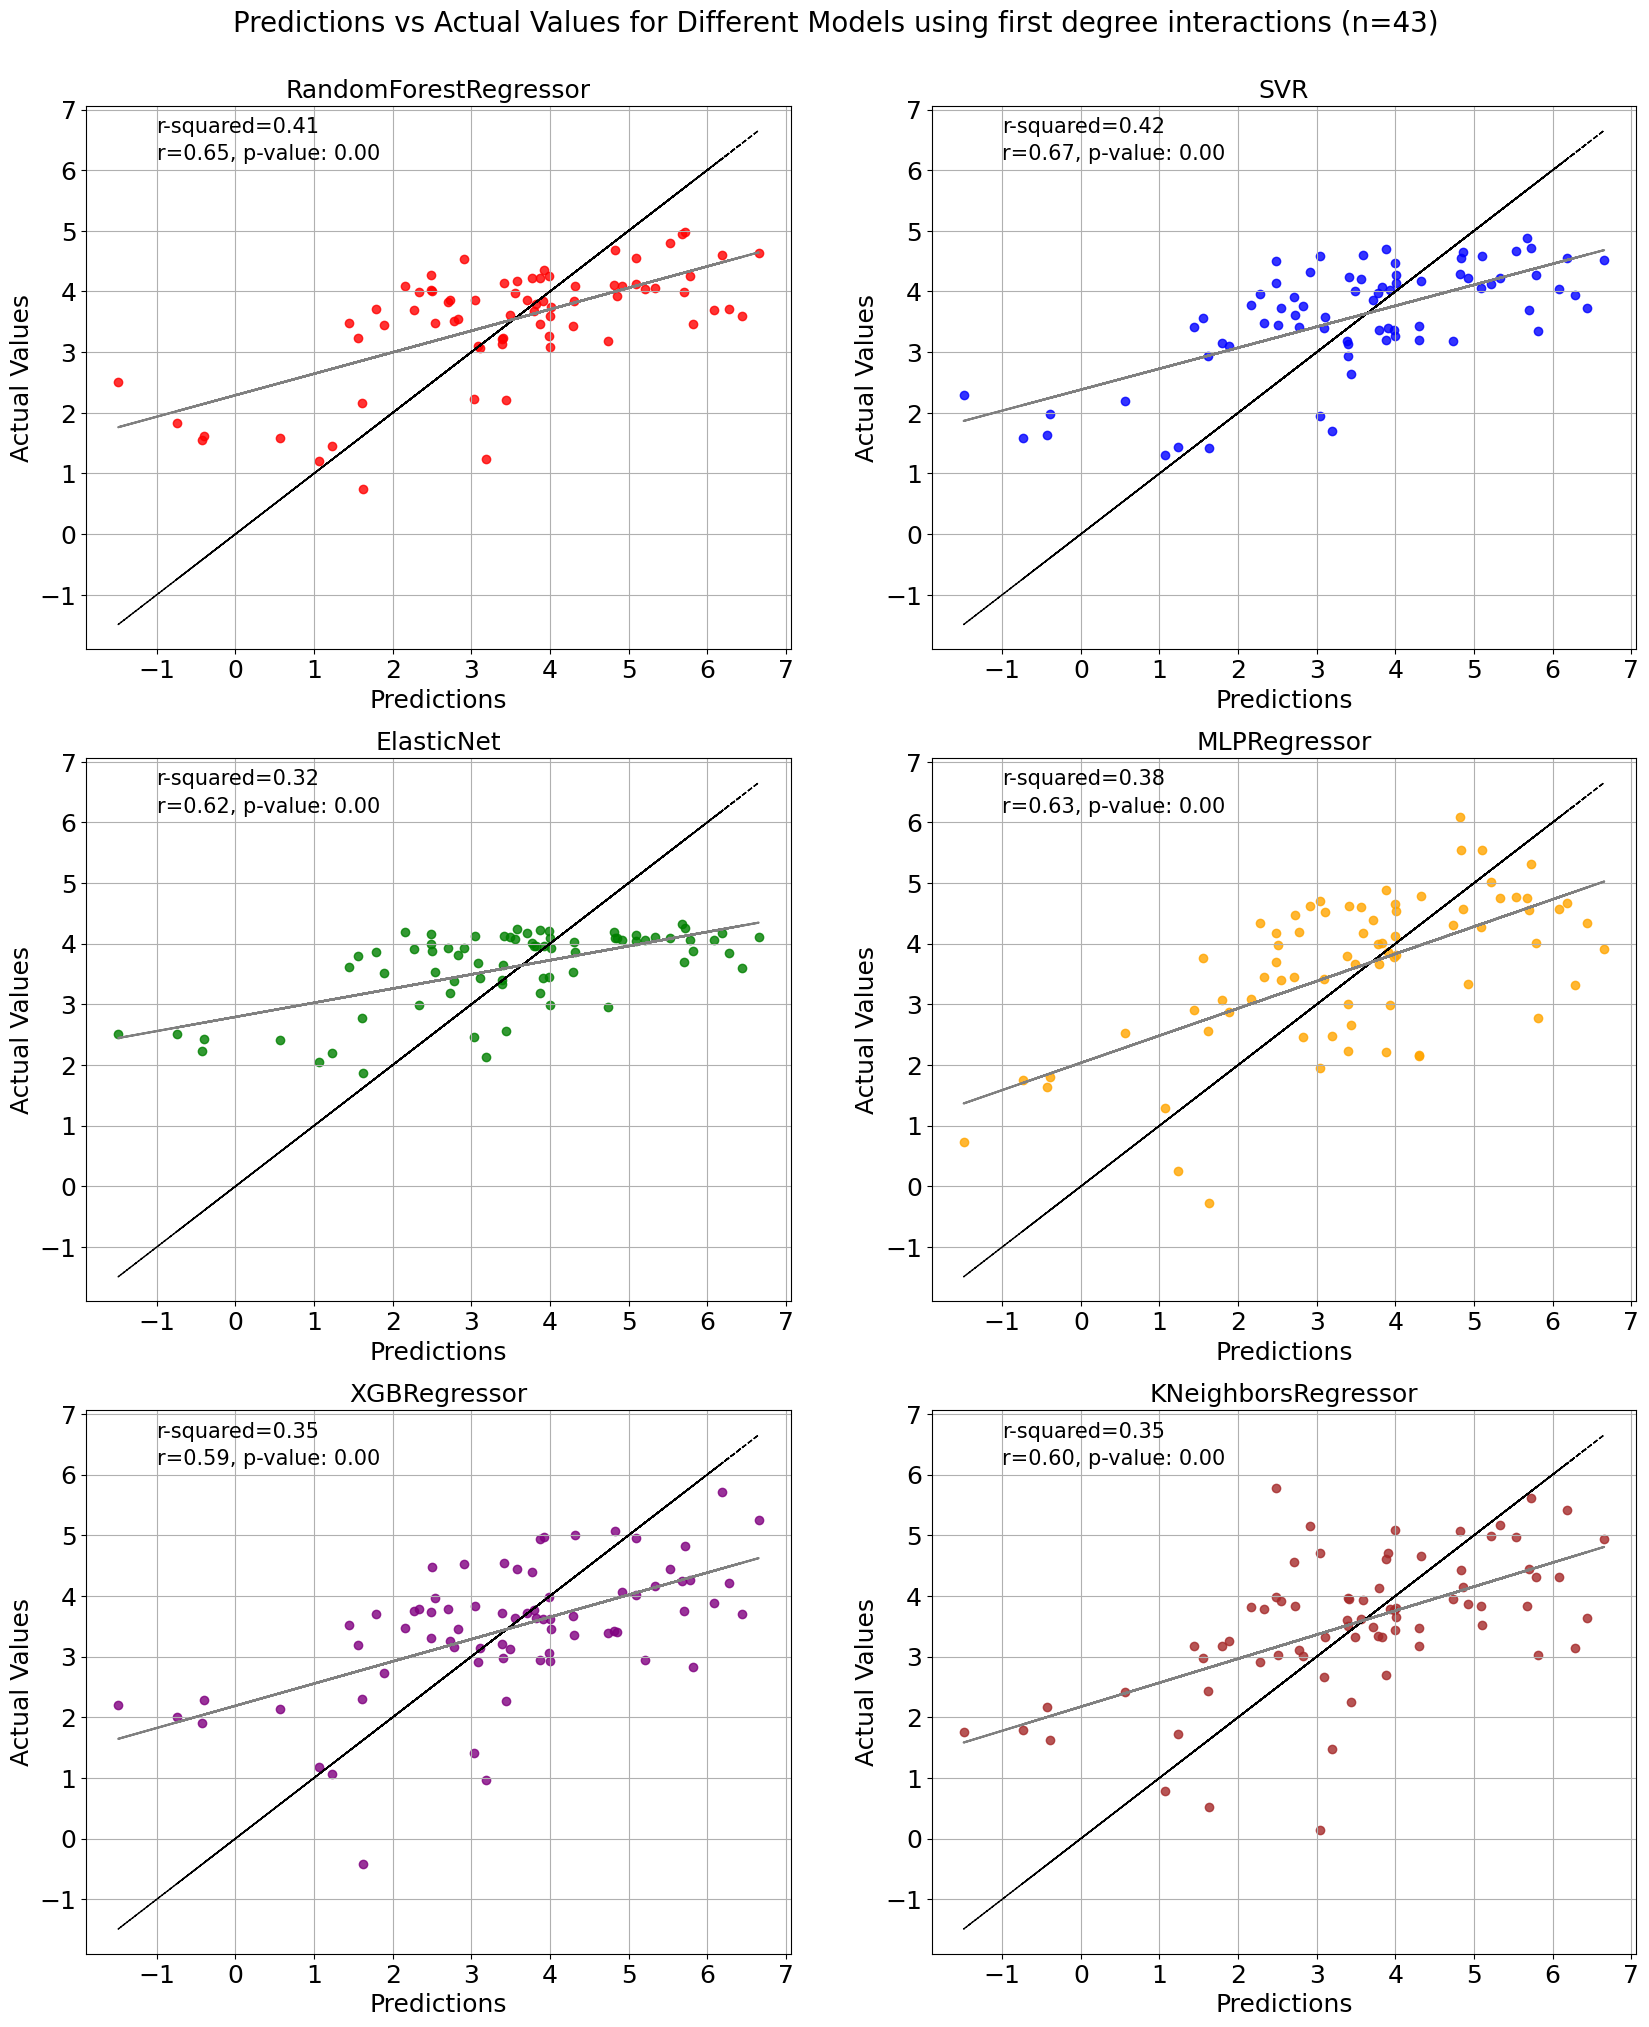

In [36]:
# plot the predictions vs the actual values
# make a 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(20, 24))

# title the overall plot

fig.suptitle(
    'Predictions vs Actual Values for Different Models using first degree interactions (n=43)', fontsize=20, y=0.92)

# use the vis module to plot the predictions vs the actual values for each model

# create six distinct colors for the plot

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i in range(len(models)):
    vis.plot_predictions_vs_actual_values(y_test,
                                          prediction_array[i],
                                          models[i].__class__.__name__,
                                          ax=ax[i//2, i % 2],
                                          x_label='Predictions', y_label='Actual Values', minitext_size=15,
                                          **{'color': colors[i], 'alpha': 0.8})


# show the plot
plt.show()


#### Conclusion

TEST SUCCESSFUL Gene Target Distance and F-test selected features can be easily combined

### Random States Generation

In [ ]:
import numpy as np

random_state_for_split = np.random.randint(1000)

random_states = []
# generate 100 random states without repetition
for i in range(100):
    rs = np.random.randint(1000)
    while rs in random_states:
        rs = np.random.randint(1000)
    random_states.append(rs)

### Test SHAP Consensus on ElasticNet with monte carlo cross validation

In [8]:
# split the data into train and test set

import Visualisation as vis
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# import random forest regression model

from sklearn.ensemble import RandomForestRegressor

# import support vector machine regression model

from sklearn.svm import SVR

# import elastic net regression model

from sklearn.linear_model import ElasticNet

# import simple mlp regression model

from sklearn.neural_network import MLPRegressor

# import xgb regression model

from xgboost import XGBRegressor

# import k nearest neighbors regression model

from sklearn.neighbors import KNeighborsRegressor

# feature selection

# import feature selection

from sklearn.feature_selection import SelectKBest, f_regression

import numpy as np

random_state_for_split = np.random.randint(1000)
random_state_for_model = np.random.randint(1000)
n_degree_neighbours = second_degree_neighbours
feature_selection_size = 100

X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=random_state_for_split)


# perform feature selection on the training set

selector = SelectKBest(f_regression, k=feature_selection_size)
selector.fit(X_train[n_degree_neighbours], y_train)

# get the selected features

selected_features = X_train[n_degree_neighbours].columns[selector.get_support()]

# print(selected_features)

# create a list of models

models = [ElasticNet()]

# fit the models

for m in models:
    # print the model name
    print('current model: ', m.__class__.__name__)
    m.fit(X_train[selected_features], y_train)

# get the predictions

prediction_array = []

for m in models:
    prediction_array.append(m.predict(X_test[selected_features]))

# get the score

score_array = []

for i in range(len(models)):
    score_array.append(mean_squared_error(y_test, prediction_array[i]))


current model:  ElasticNet


In [79]:
random_states = []
# generate 10 random states without repetition
for i in range(100):
    rs = np.random.randint(1000)
    while rs in random_states:
        rs = np.random.randint(1000)
    random_states.append(rs)

In [114]:
# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import shap 

data_collector = []

for rng in random_states:
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=rng)
    sel_train, sel_test = X_train[selected_features], X_test[selected_features]
    model = ElasticNet()
    model.fit(sel_train, y_train)
    prediction = model.predict(sel_test)
    y_pred = model.predict(sel_test)
    score = mean_squared_error(y_test, y_pred)
    corr, p_val = pearsonr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    explainer = shap.LinearExplainer(model, sel_train)
    # explainer = shap.KernelExplainer(model.predict, sel_train) # long runtime
    shap_values = explainer.shap_values(sel_test)

    data_collector.append([rng, score, corr, p_val, r_squared, shap_values, sel_train, sel_test, y_test, y_pred])
    # print debug msg, print all metrics, within 2 decimal places
    # print('random state: ', rng, 'score: ', round(score, 2), 'corr: ', round(corr, 2), 'p_val: ', round(p_val, 2), 'r_squared: ', round(r_squared, 2))

df = pd.DataFrame(data_collector, columns=['random_state', 'score', 'corr', 'p_val', 'r_squared', 'shap_values', 'X_train', 'X_test', 'y_test', 'y_pred'])
df.head()

,random_state,score,corr,p_val,r_squared,shap_values,X_train,X_test,y_test,y_pred
0,59,1.778337,0.651896,3.153999e-10,0.353824,"[[0.0, 0.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0,...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00437 -1.491216 SIDM00659 5.088799 SI...,"[2.4742818860197633, 4.215201635238978, 4.0438..."
1,267,2.019403,0.664706,1.060484e-10,0.361061,"[[-0.0, -0.0, 0.030549506170890958, -0.0, 0.0,...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM01181 3.504866 SIDM00887 4.642324 SI...,"[3.5162613852947433, 3.9276424106144834, 4.180..."
2,140,1.429145,0.648785,4.078158e-10,0.379960,"[[-0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00508 3.496911 SIDM00879 4.919406 SI...,"[3.521036186834996, 4.050163435280439, 4.21596..."
3,972,1.782811,0.538073,7.644215e-07,0.281154,"[[0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, -0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00653 5.492558 SIDM00427 3.175622 SI...,"[3.2974661473102906, 2.649814416489881, 4.2052..."
4,690,1.952273,0.605859,1.068320e-08,0.338373,"[[-0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0....",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00237 3.946046 SIDM01012 0.301840 SI...,"[4.01565311325424, 2.504976720500458, 2.364444..."


In [115]:
# print mean pearson correlation coefficient and r squared

print('mean pearson correlation coefficient: ', df['corr'].mean())
print('mean r squared: ', df['r_squared'].mean())

mean pearson correlation coefficient:  0.5573591486481727
mean r squared:  0.27965078019828077


In [82]:
# print one row of the shap values

df['shap_values'][0]

# compute absolute mean of the shap values

shap_values = np.abs(df['shap_values'][0]).mean(axis=0)

# get the column names

column_names = df['X_test'][0].columns

# join the column names and the shap values

shap_df = pd.DataFrame(list(zip(column_names, shap_values)), columns=['feature', 'shap_value'])

# sort the dataframe by shap values

shap_df.sort_values(by=['shap_value'], ascending=False, inplace=True)

# print the dataframe

shap_df.head(10)

# df['X_test'][0]

# # plot the shap values  

# import matplotlib.pyplot as plt

# # plot the shap values for the first row of the shap values

# shap.summary_plot(df['shap_values'][0][0], df['X_test'][0], plot_type='bar')

,feature,shap_value
42,Q9UBI6;GBG12_HUMAN,0.205972
19,P07305;H10_HUMAN,0.096895
73,P14923;PLAK_HUMAN,0.094470
38,P02545;LMNA_HUMAN,0.087135
49,P32519;ELF1_HUMAN,0.057074
77,Q03135;CAV1_HUMAN,0.046231
26,Q07817;B2CL1_HUMAN,0.039194
22,P15151;PVR_HUMAN,0.029878
13,P35222;CTNB1_HUMAN,0.016062
60,P40227;TCPZ_HUMAN,0.000000


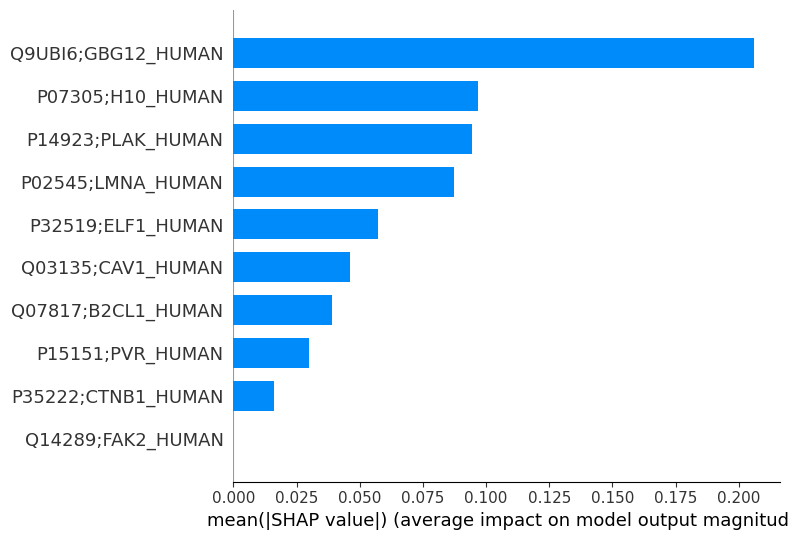

In [83]:
# plot 

shap.summary_plot(df['shap_values'][0], df['X_test'][0], plot_type='bar', max_display=10)

<AxesSubplot: >

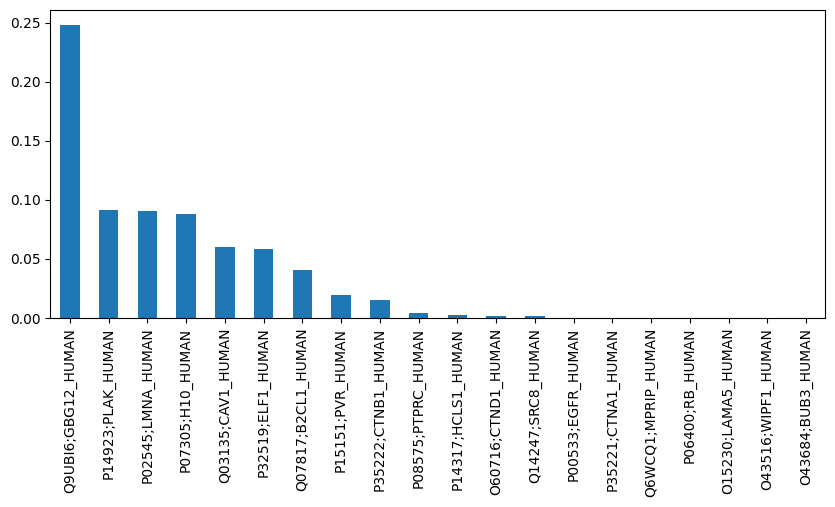

In [112]:
# extract all the shap values, match the feature names and store them in a dataframe
collector = []
for shap, x_test in zip(df['shap_values'], df['X_test']):
    # print(shap.shape, cols.shape)
    mean_shap = np.abs(shap).mean(axis=0)
    column_names = x_test.columns
    joint_data = list(zip(column_names, mean_shap))
    # sort the joint data by column names
    joint_data.sort(key=lambda x: x[0])
    collector.append(joint_data)

# create a dataframe from the collector

# first, create a list of column names

column_names = [x[0] for x in collector[0]]

shap_df = pd.DataFrame(collector, columns=column_names)

# for every cell in the dataframe, keep only the shap value, which is the second element in the tuple

for col in shap_df.columns:
    shap_df[col] = shap_df[col].apply(lambda x: x[1])

# sort the dataframe columns by the mean shap values

shap_df = shap_df.reindex(shap_df.mean().sort_values(ascending=False).index, axis=1)
shap_df.head()


# compute the mean shap values for each column

mean_shap_values = shap_df.mean()

# print the mean shap values, with respect to the column names, in descending order, with 2 decimal places

# for col, val in mean_shap_values.sort_values(ascending=False).iteritems():
#     print(col, val)

# plot the mean shap values

plot_only_num_cols = 20

mean_shap_values.sort_values(ascending=False)[:plot_only_num_cols].plot(kind='bar', figsize=(10, 4))

# mean_shap_values.sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))
    

SUCCESS This section used the random states to perform 10 monte carlo cross validations and then computed the mean of the mean absolute shap values for each feature. This provides a more robust feature importance metric.

#### Backward Knockout Test

##### Knocking Out Single Feature 

In [85]:
# remove Q9UBI6 from the selected features

dropped_features = selected_features.drop('Q9UBI6;GBG12_HUMAN')

In [86]:
# test the model with the dropped features

# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import shap 

data_collector = []

for rng in random_states:
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=rng)
    sel_train, sel_test = X_train[dropped_features], X_test[dropped_features]
    model = ElasticNet()
    model.fit(sel_train, y_train)
    prediction = model.predict(sel_test)
    y_pred = model.predict(sel_test)
    score = mean_squared_error(y_test, y_pred)
    corr, p_val = pearsonr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    explainer = shap.LinearExplainer(model, sel_train)
    shap_values = explainer.shap_values(sel_test)

    data_collector.append([rng, score, corr, p_val, r_squared, shap_values, sel_train, sel_test, y_test, y_pred])
    # print debug msg, print all metrics, within 2 decimal places
    # print('random state: ', rng, 'score: ', round(score, 2), 'corr: ', round(corr, 2), 'p_val: ', round(p_val, 2), 'r_squared: ', round(r_squared, 2))

dropped_df = pd.DataFrame(data_collector, columns=['random_state', 'score', 'corr', 'p_val', 'r_squared', 'shap_values', 'X_train', 'X_test', 'y_test', 'y_pred'])
dropped_df.head()

,random_state,score,corr,p_val,r_squared,shap_values,X_train,X_test,y_test,y_pred
0,59,1.826687,0.635553,1.177910e-09,0.336255,"[[0.0, 0.0, -0.018327510636034373, -0.0, 0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00437 -1.491216 SIDM00659 5.088799 SI...,"[2.5468815947264996, 4.16358105212926, 4.05883..."
1,267,2.080423,0.644664,5.705940e-10,0.341754,"[[-0.0, -0.0, 0.037678829669261824, -0.0, 0.0,...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM01181 3.504866 SIDM00887 4.642324 SI...,"[3.441927198485783, 3.8789954214507087, 4.0819..."
2,140,1.388349,0.678442,3.101450e-11,0.397660,"[[-0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00508 3.496911 SIDM00879 4.919406 SI...,"[3.528632355237748, 3.998625734714497, 4.19317..."
3,972,1.832163,0.517647,2.323940e-06,0.261254,"[[0.0, 0.0, 0.0047179151840294285, -0.0, 0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00653 5.492558 SIDM00427 3.175622 SI...,"[3.1935986922184227, 3.0524525129122, 4.162753..."
4,690,2.009905,0.590495,3.066695e-08,0.318841,"[[-0.0, 0.0, 0.0017246750356653918, 0.0, 0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00237 3.946046 SIDM01012 0.301840 SI...,"[3.9767220589245884, 2.602812224186406, 2.4989..."


In [87]:
# print mean pearson correlation coefficient and r squared

print('mean pearson correlation coefficient: ', dropped_df['corr'].mean())
print('mean r squared: ', dropped_df['r_squared'].mean())

mean pearson correlation coefficient:  0.5566803981659745
mean r squared:  0.27447410306673836


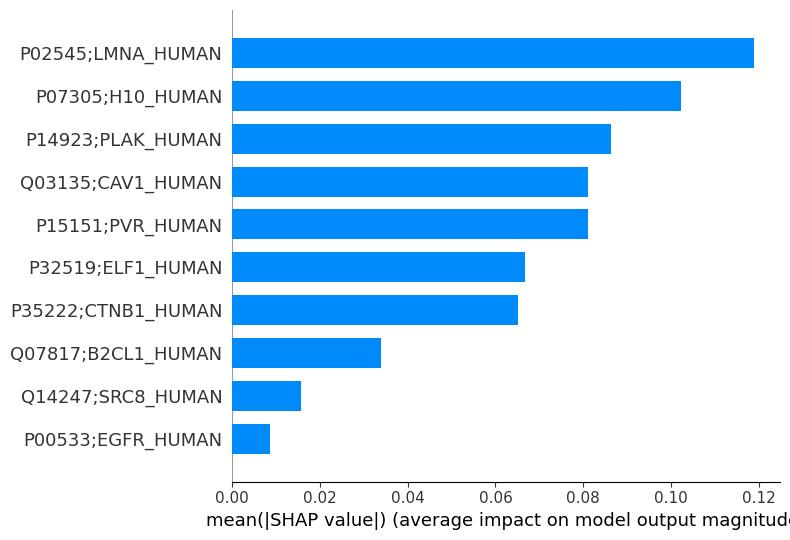

In [88]:
shap.summary_plot(dropped_df['shap_values'][0], dropped_df['X_test'][0], plot_type='bar', max_display=10)


##### Knocking Out Multiple Features

In [106]:
# knockout the five features with the highest shap values

# get the first five column names of shap_df

top_five_features = shap_df.columns[:5]

# drop the top five features from the selected features

dropped_features = selected_features.drop(top_five_features)

print(top_five_features)
print('dropped features: ', dropped_features.shape)





Index(['Q9UBI6;GBG12_HUMAN', 'P14923;PLAK_HUMAN', 'P02545;LMNA_HUMAN',
       'P07305;H10_HUMAN', 'Q03135;CAV1_HUMAN'],
      dtype='object')
dropped features:  (95,)


Visualising the feature from its distribution and its association with the target

In [119]:
plot_df = joined_sin_peptile_exclusion_matrix.loc[:, top_five_features]


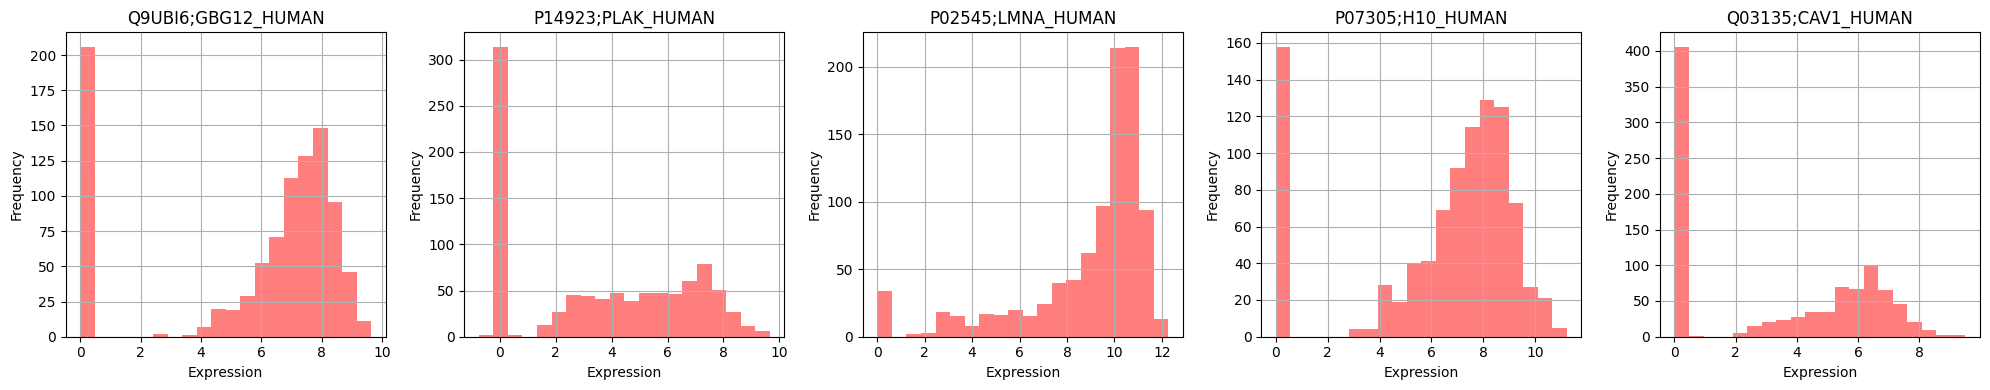

In [138]:
# plot the top five features as five histograms using matplotlib
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(axes.flatten()):
    col = plot_df.columns[i]
    plot_df[col].plot(kind='hist', bins=20, ax=axes[i], color='red', alpha=0.5)
    axes[i].grid()
    axes[i].set_title(col)
    axes[i].set_xlabel('Expression')
plt.tight_layout()

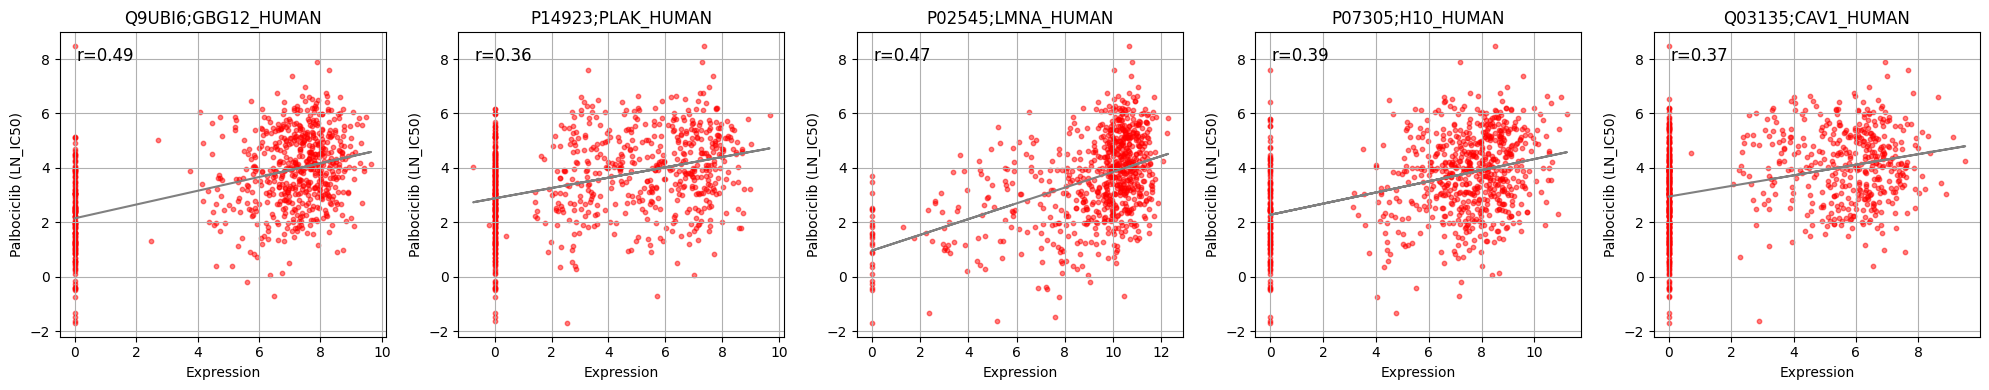

In [139]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes.flatten()):
    col = plot_df.columns[i]
    # plot correlation
    X = palbociclib_proteomic_df[col]
    Y = palbociclib_proteomic_df['LN_IC50']
    ax.scatter(X, Y, color='red', alpha=0.5, s=10)
    m, b = np.polyfit(X, Y, 1)
    ax.plot(X, m*X + b, color='grey')
    corr = str(round(np.corrcoef(X, Y)[0, 1], 2))

    # insert annotations
    axes[i].grid()
    ax.text(0.05, 0.95, f'r={corr}', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_title(f'{col}')
    ax.set_xlabel('Expression')
    ax.set_ylabel('Palbociclib (LN_IC50)')

plt.tight_layout()
plt.show()




In [107]:
# test the model with the dropped features

# iterate feature selection for {repeat} times 
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

import shap 

data_collector = []

for rng in random_states:
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1,
                                                    random_state=rng)
    sel_train, sel_test = X_train[dropped_features], X_test[dropped_features]
    model = ElasticNet()
    model.fit(sel_train, y_train)
    prediction = model.predict(sel_test)
    y_pred = model.predict(sel_test)
    score = mean_squared_error(y_test, y_pred)
    corr, p_val = pearsonr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)

    explainer = shap.LinearExplainer(model, sel_train)
    shap_values = explainer.shap_values(sel_test)

    data_collector.append([rng, score, corr, p_val, r_squared, shap_values, sel_train, sel_test, y_test, y_pred])
    # print debug msg, print all metrics, within 2 decimal places
    # print('random state: ', rng, 'score: ', round(score, 2), 'corr: ', round(corr, 2), 'p_val: ', round(p_val, 2), 'r_squared: ', round(r_squared, 2))

dropped_df = pd.DataFrame(data_collector, columns=['random_state', 'score', 'corr', 'p_val', 'r_squared', 'shap_values', 'X_train', 'X_test', 'y_test', 'y_pred'])
dropped_df.head()

,random_state,score,corr,p_val,r_squared,shap_values,X_train,X_test,y_test,y_pred
0,59,1.846722,0.639744,8.464620e-10,0.328975,"[[0.0, 0.0, -0.07654307009260837, -0.0, 0.0, -...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00437 -1.491216 SIDM00659 5.088799 SI...,"[2.3880812656935846, 4.118212664874623, 3.8543..."
1,267,2.135932,0.645242,5.445020e-10,0.324191,"[[-0.0, -0.0, 0.054360952346131274, -0.0, 0.0,...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM01181 3.504866 SIDM00887 4.642324 SI...,"[3.539409682625939, 3.955993334498854, 4.00973..."
2,140,1.396714,0.690965,9.532811e-12,0.394030,"[[-0.0, 0.0, 0.007532272480437943, -0.0, 0.0, ...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00508 3.496911 SIDM00879 4.919406 SI...,"[3.680354936411743, 4.0031247712371965, 4.1382..."
3,972,1.842072,0.518705,2.197760e-06,0.257259,"[[0.0, 0.0, 0.0193505133122807, -0.0, 0.0, -0....",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00653 5.492558 SIDM00427 3.175622 SI...,"[3.3992690440596496, 3.2166980593464753, 4.167..."
4,690,1.942930,0.627470,2.197023e-09,0.341539,"[[-0.0, 0.0, 0.014360498552277907, 0.0, 0.0, -...",P33316;DUT_HUMAN P27986;P85A_HUMAN...,P33316;DUT_HUMAN P27986;P85A_HUMAN...,SIDM00237 3.946046 SIDM01012 0.301840 SI...,"[3.8796962444336023, 2.3391107813396044, 2.353..."


In [108]:
# print mean pearson correlation coefficient and r squared

print('mean pearson correlation coefficient: ', dropped_df['corr'].mean())
print('mean r squared: ', dropped_df['r_squared'].mean())

mean pearson correlation coefficient:  0.5608168846606787
mean r squared:  0.27252498288666865


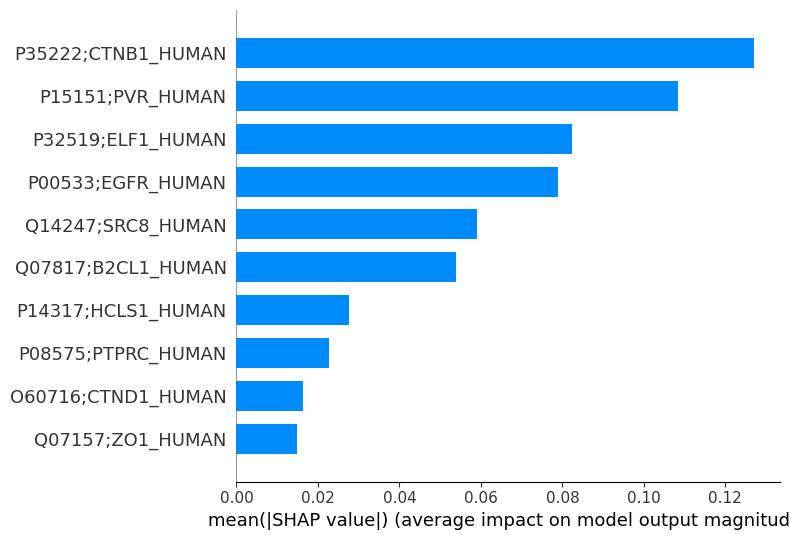

In [109]:
shap.summary_plot(dropped_df['shap_values'][0], dropped_df['X_test'][0], plot_type='bar', max_display=10)

Preliminary results show that knocking out multiple features barely reduced the performance of the model. When features with high mean of mean SHAP absolute values were knocked out, other features almost appear to take their place by having increased mean of mean SHAP absolute values. This is a very interesting result and should be investigated further.

## Notes

Forward test and backward tests for final, selected features

Forward test: Compare selected features of size n against random features of size n for model performance in multiple models

Backward test: Remove selected features of size n from all features and compare model performance in multiple models